# Introduction

## Objective
Develop a model that classifies clouds into one of two types. 

## Key findings
* A classifier with very high accuracy has been developed that is ready for production. 

## Next steps
* Move model over to scripts for productionalization

## Imports and setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import sys
import os
import json
import warnings
warnings.filterwarnings('ignore')

# basic plotting and data manipulation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For modeling
import sklearn
import sklearn.ensemble

# for appending dates to filenames
import datetime

In [2]:
from cycler import cycler

# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': 16,
    'axes.prop_cycle': cycler('color', ['#0085ca', '#888b8d', '#00c389', '#f4364c', '#e56db1']),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [12.0, 8.0],
    'axes.labelsize': 20,
    'axes.labelcolor': '#677385',
    'axes.titlesize': 20,
    'lines.color': '#0055A7',
    'lines.linewidth': 3,
    'text.color': '#677385',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Tahoma'
}
mpl.rcParams.update(mpl_update)

In [3]:
# Prepends the date to a string (e.g. to save dated files)
# dateplus("cool-figure.png") -> "2018-12-05-cool-figure.png"
now = datetime.datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

# Create dataset

The data from the following analysis is from the [ University of California Irvine machine learning repository](https://archive.ics.uci.edu/ml/datasets/Cloud)

## Acquire data

The following command downloads it (`!` will execute the command from the command line): 

In [4]:
! curl -o clouds.data https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  204k  100  204k    0     0   344k      0 --:--:-- --:--:-- --:--:--  344k


The top of the file describes the dataset: 

In [5]:
! sed -n '21,50p' clouds.data

;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

;                   CLOUD DATABASE
;The data sets we propose to analyse are constituted of 1024 vectors, each
;vector includes 10 parameters. You can think of it as a 1024*10 matrix.
;To produce these vectors, we proceed as follows:
;
;	- we start with two 512*512 AVHRR images 
;	  (1 in the visible, 1 in the IR)
;	- each images is divided in super-pixels 16*16 and in each
;	  super-pixel we compute a set of parameters.
;
;		visible: mean, max, min, mean distribution, contrast,
;			 entropy, second angular momentum
;		IR: mean, max, min

;The set of 10 parameters we picked to form the vectors is a compromised between
;various constraints. Actually we are still working on the choice of parameters
;for the data vectors. The data set I send you has not been normalized. The
;normalization of the data set is required by our classification scheme but that
;may not be true for yours. To normalize the data we compute the mean and


Dataset column names

In [6]:
columns = ['visible_mean', 'visible_max', 'visible_min', 
           'visible_mean_distribution', 'visible_contrast', 
           'visible_entropy', 'visible_second_angular_momentum', 
           'IR_mean', 'IR_max', 'IR_min']

## Import data

In [7]:
with open("clouds.data",'r') as f:
    data = [[s for s in line.split(' ') if s!=''] for line in f.readlines()]

## Get first cloud class

### Identify first row of data

In [8]:
print(data[52])

['\n']


In [9]:
print(data[53])

['3.0000', '140.0000', '43.5000', '0.0833', '862.8417', '0.0254', '3.8890', '163.0000', '240.0000', '213.3555\n']


### Identify last row of data

In [10]:
print(data[1076])

['8.0000', '85.0000', '18.2852', '0.0186', '73.5792', '0.1540', '2.4113', '220.0000', '245.0000', '239.7813\n']


In [11]:
print(data[1077])

['\n']


In [12]:
first_cloud = data[53:1077]

first_cloud = [[float(s.replace('/n', '')) for s in cloud]
               for cloud in first_cloud]
first_cloud = pd.DataFrame(first_cloud, columns=columns)

first_cloud['class'] = np.zeros(len(first_cloud))

## Get second cloud class

### Identify first row

In [13]:
data[1081]

['\n']

In [14]:
print(data[1082])

['4.7150', '100.8120', '27.0538', '8.6458', '168.5875', '0.0772', '3.0616', '-5.3320', '36.5493', '23.5057\n']


### Identify last row

In [15]:
print(data[2105])

['4.9299', '31.5877', '14.6402', '1.7875', '7.3292', '0.2153', '1.7980', '-52.3305', '34.0016', '4.5046\n']


In [16]:
print(data[2106])

['\n']


In [17]:
second_cloud = data[1082:2105]

second_cloud = [[float(s.replace('/n', '')) for s in cloud]
                for cloud in second_cloud]

second_cloud = pd.DataFrame(second_cloud, columns=columns)

second_cloud['class'] = np.ones(len(second_cloud))

Concatenate dataframes for training

In [18]:
data = pd.concat([first_cloud, second_cloud])

# Generate features

In [19]:
data.head()

,visible_mean,visible_max,visible_min,visible_mean_distribution,visible_contrast,visible_entropy,visible_second_angular_momentum,IR_mean,IR_max,IR_min,class
0,3.0,140.0,43.5000,0.0833,862.8417,0.0254,3.8890,163.0,240.0,213.3555,0.0
1,3.0,135.0,41.9063,0.0790,690.3291,0.0259,3.8340,167.0,239.0,213.7188,0.0
2,2.0,126.0,21.0586,0.0406,308.3583,0.0684,3.1702,174.0,240.0,227.5859,0.0
3,4.0,197.0,77.4805,0.0890,874.4709,0.0243,3.9442,155.0,239.0,197.2773,0.0
4,7.0,193.0,88.8398,0.0884,810.1126,0.0223,3.9318,150.0,236.0,186.0195,0.0


In [20]:
features = data[columns]

target = data["class"]

## Additional features, transformations, and interactions

In [21]:
features['log_entropy'] = features.visible_entropy.apply(np.log)

In [22]:


features['entropy_x_contrast'] = features.visible_contrast.multiply(
    features.visible_entropy)



In [23]:
features['IR_range']  = features.IR_max - features.IR_min

In [24]:
features['IR_norm_range'] = (features.IR_max - features.IR_min).divide(
    features.IR_mean)

## Exploratory data analysis

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

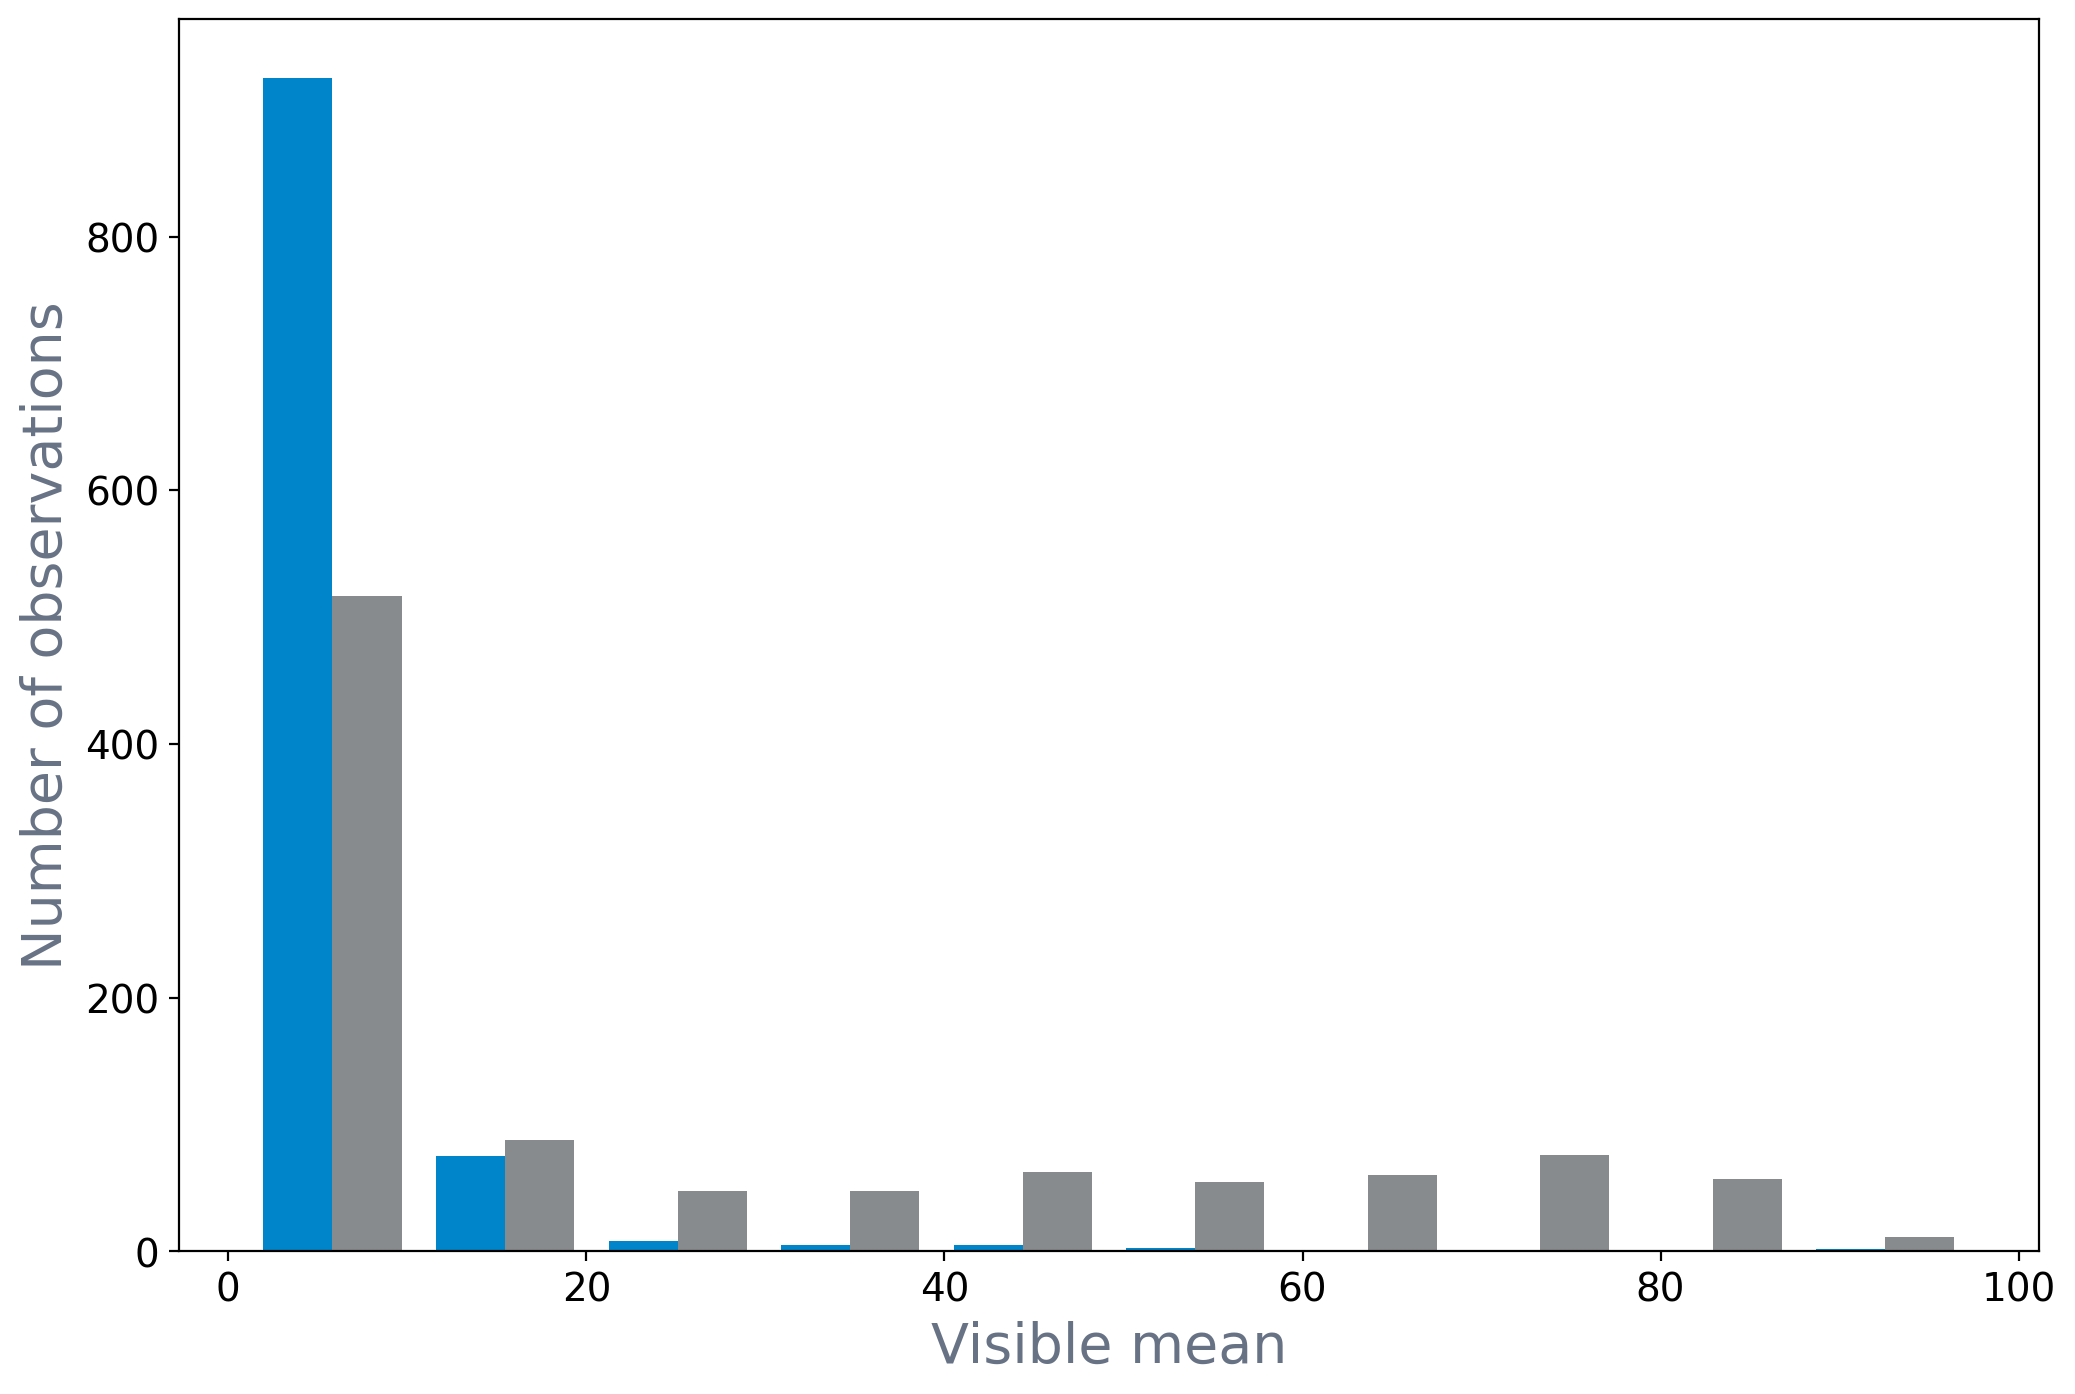

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

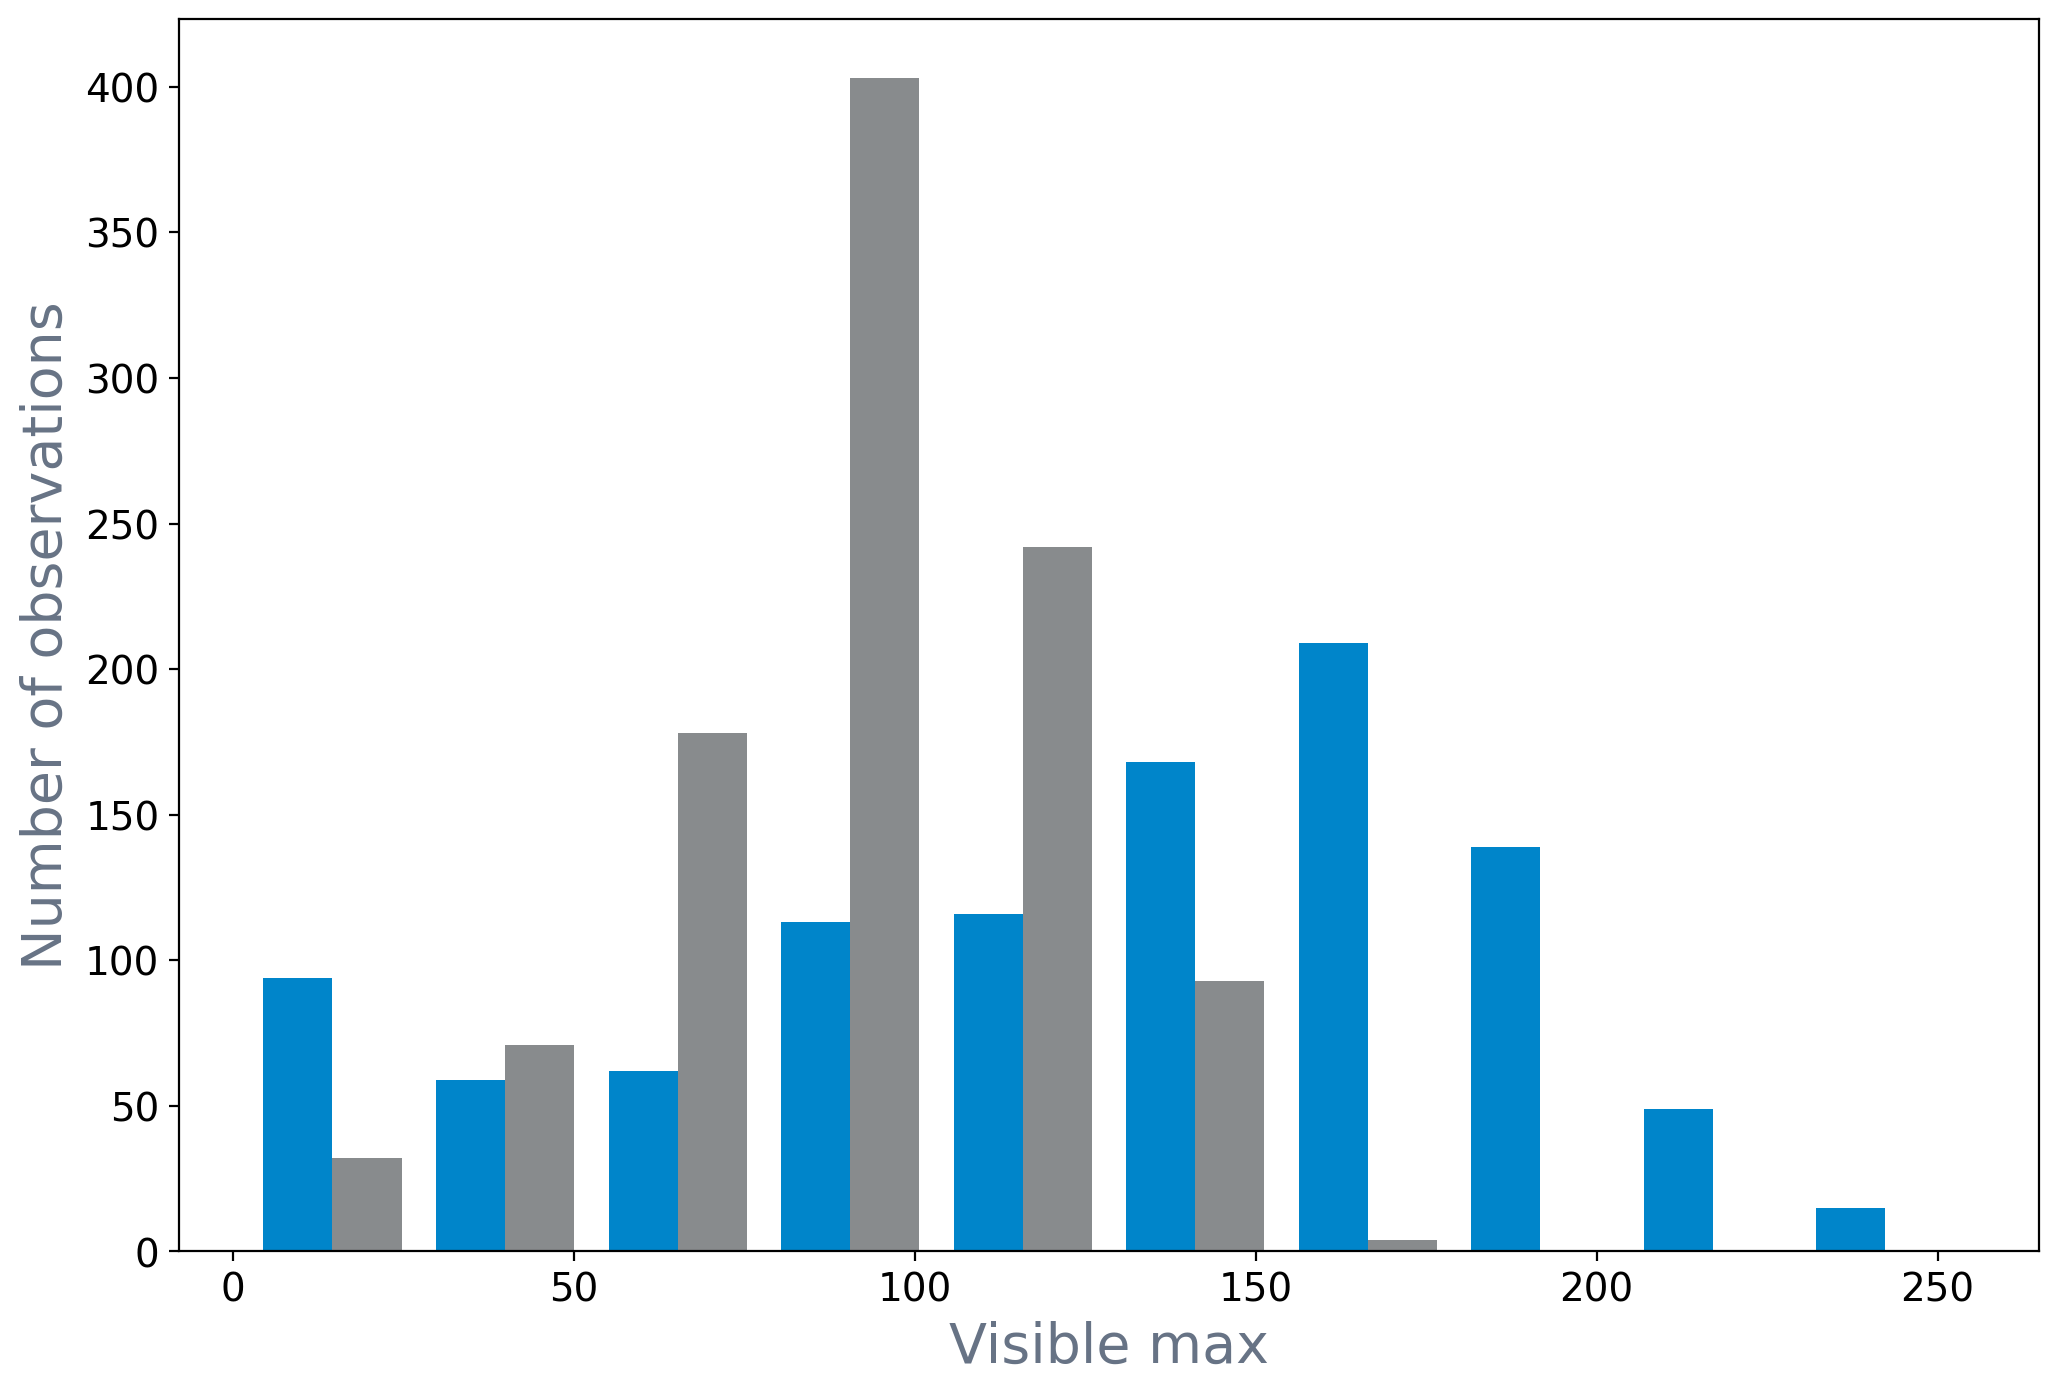

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

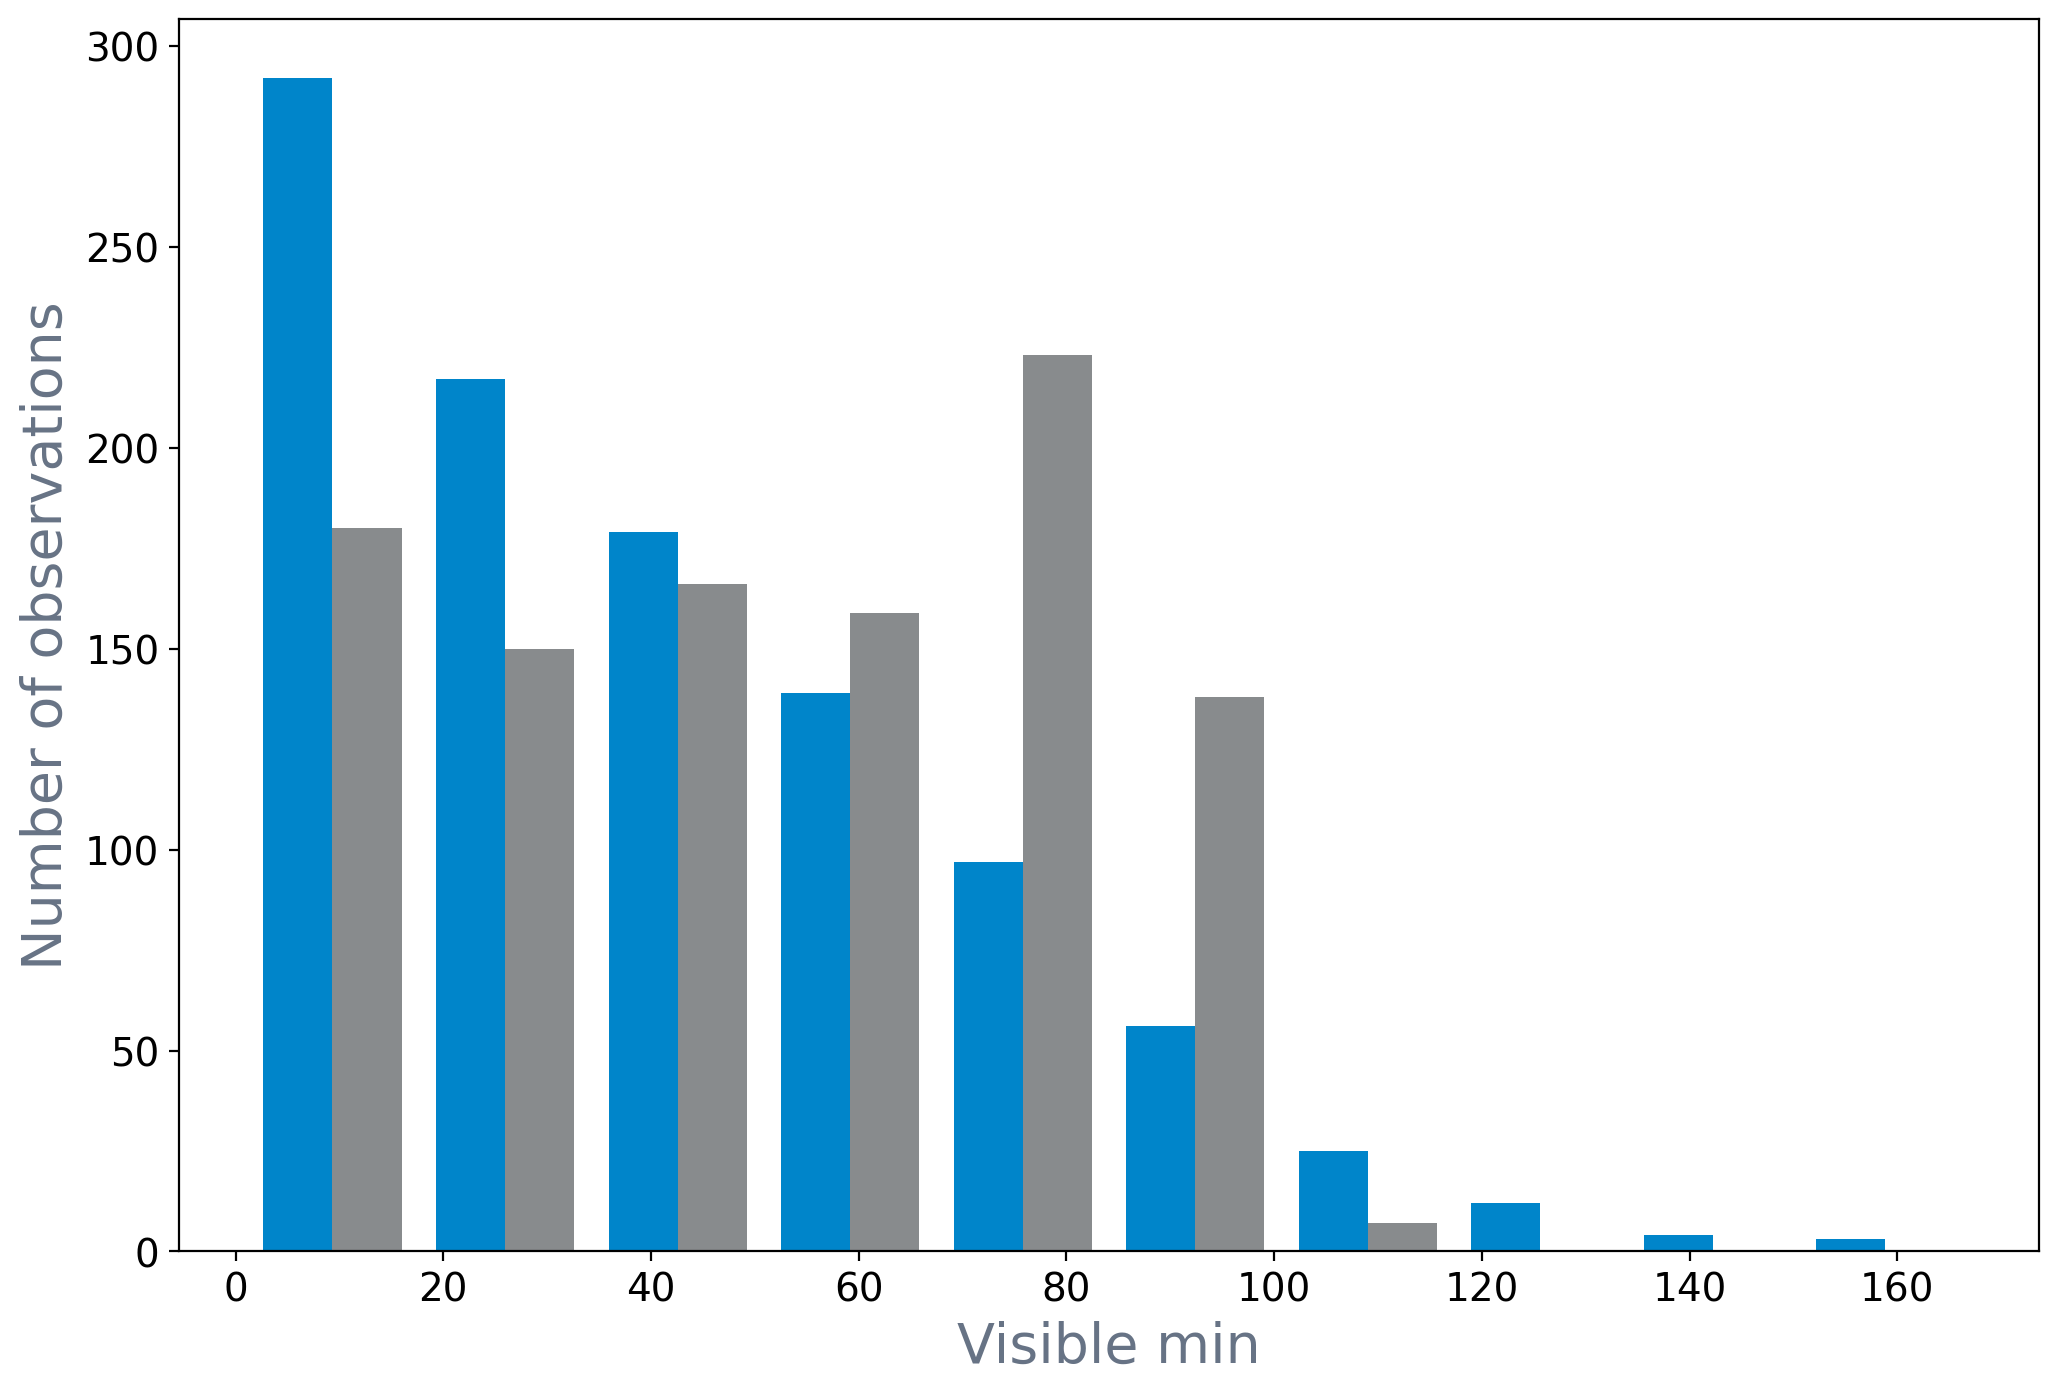

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

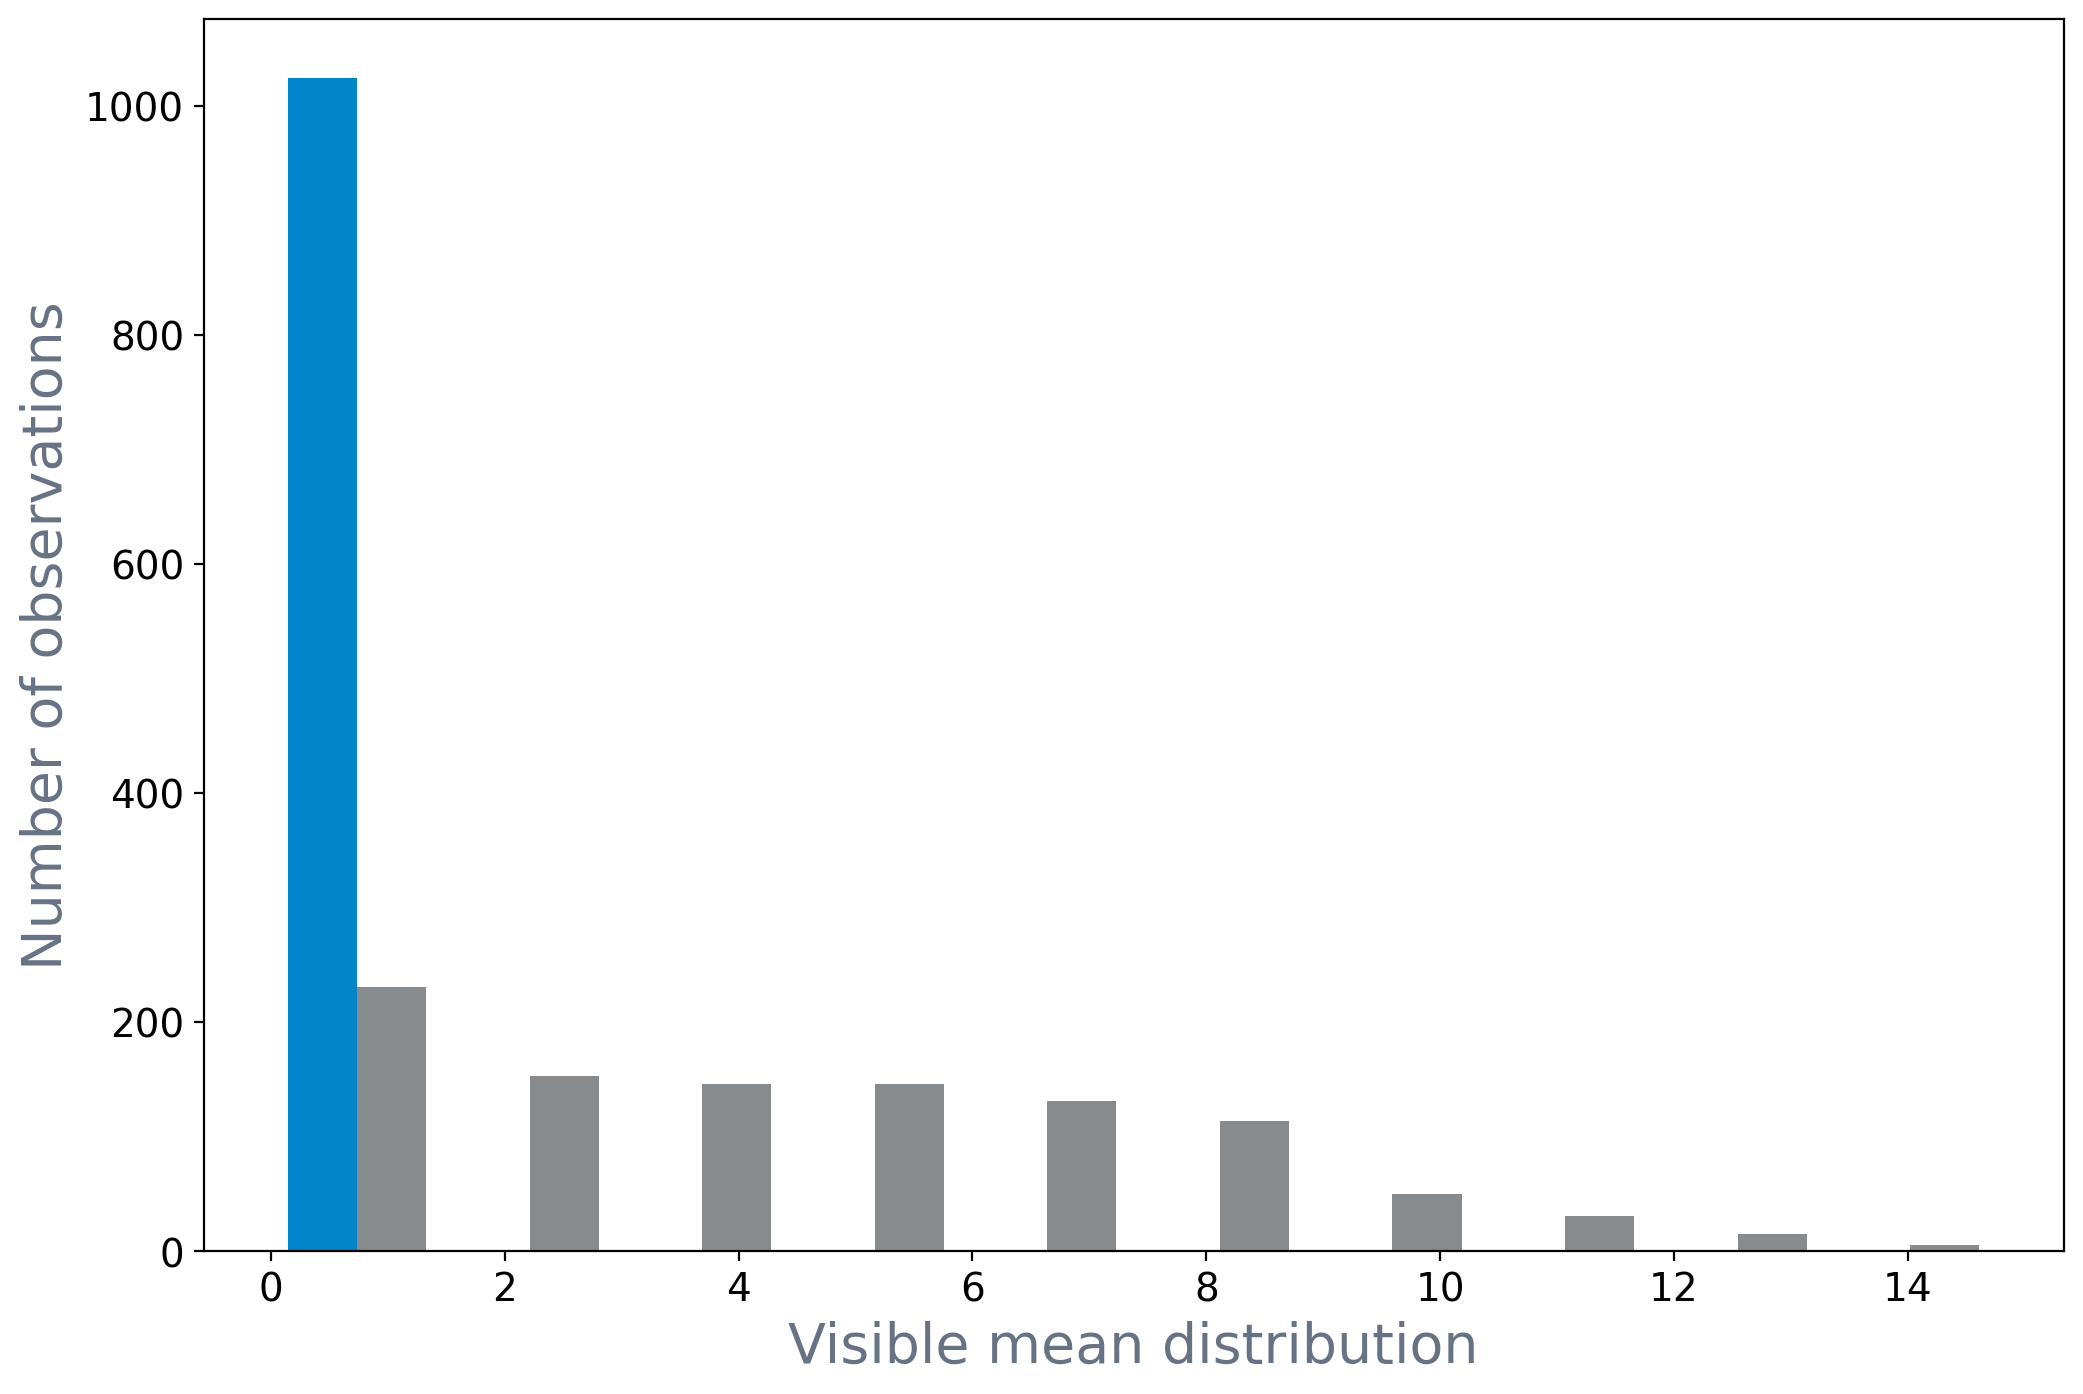

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

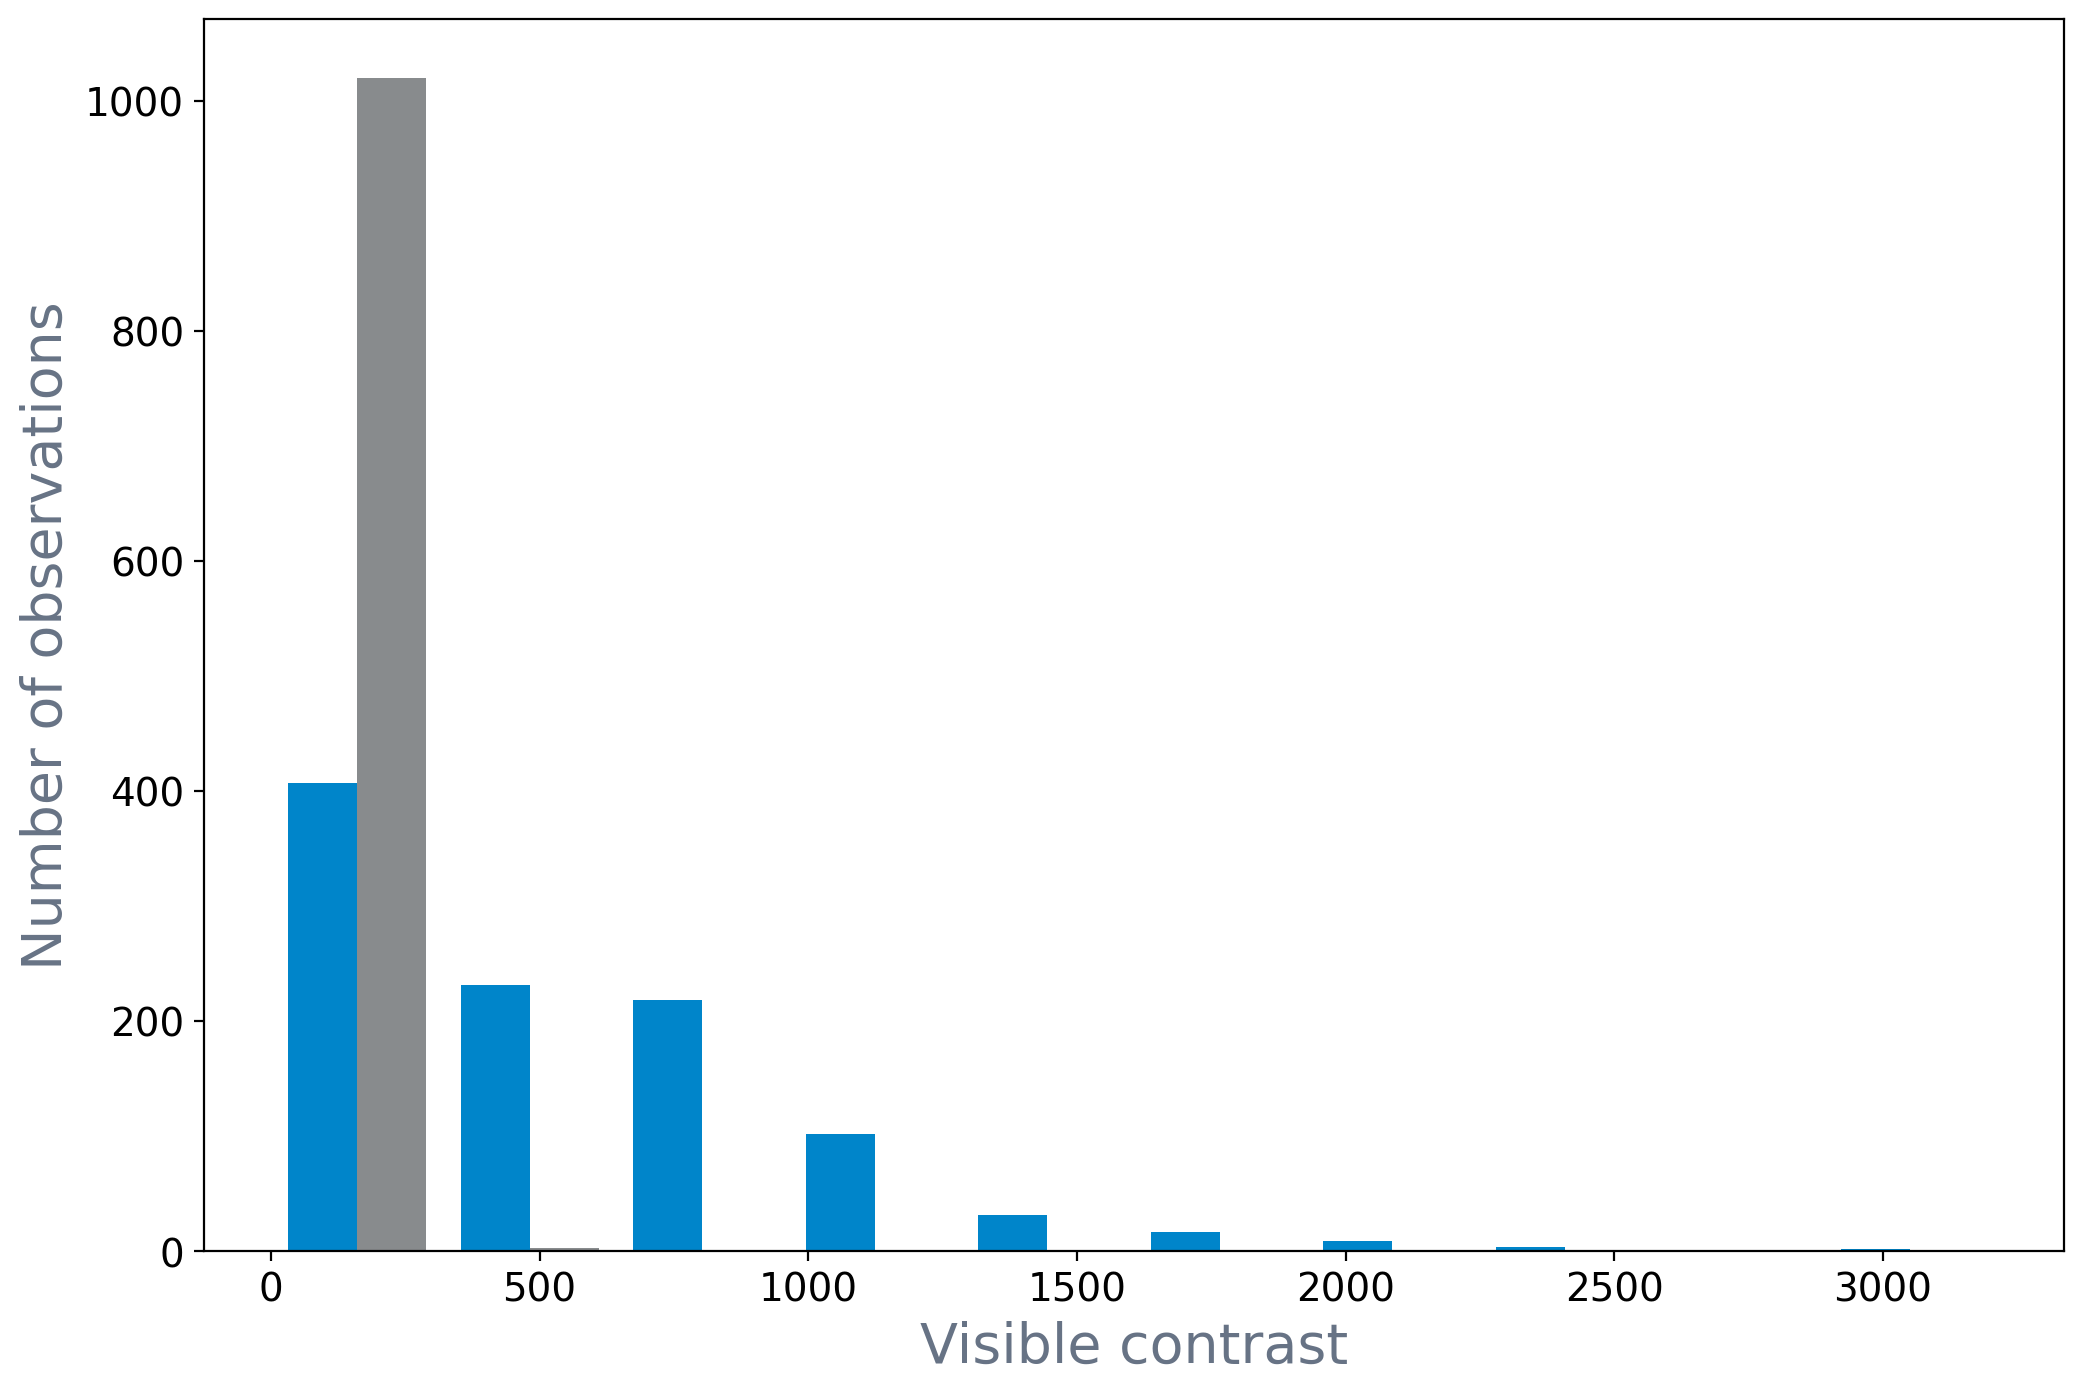

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

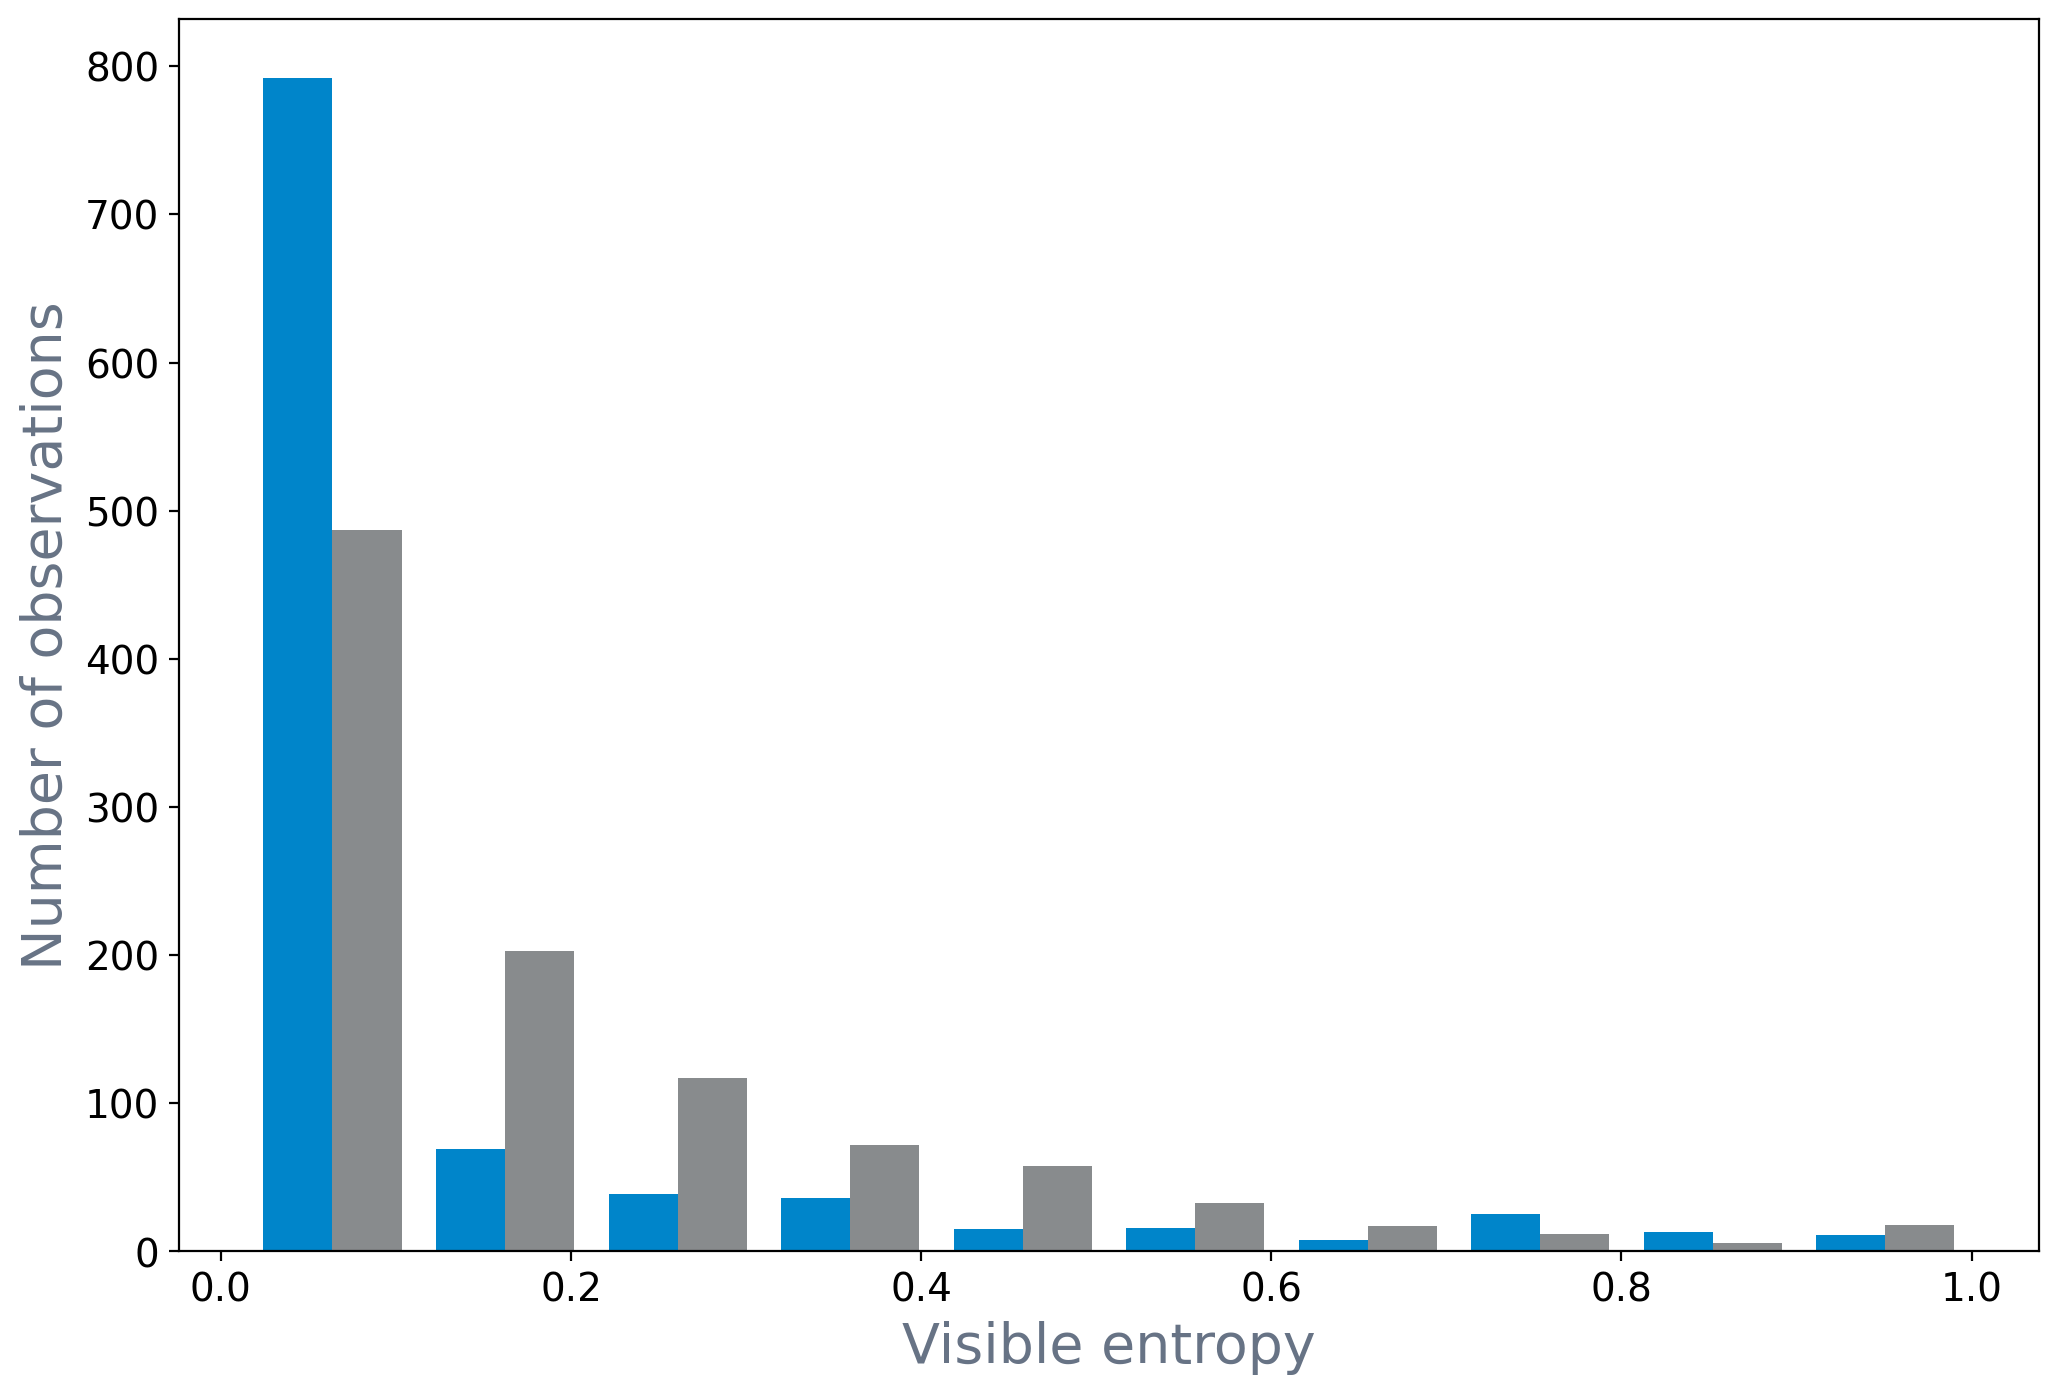

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

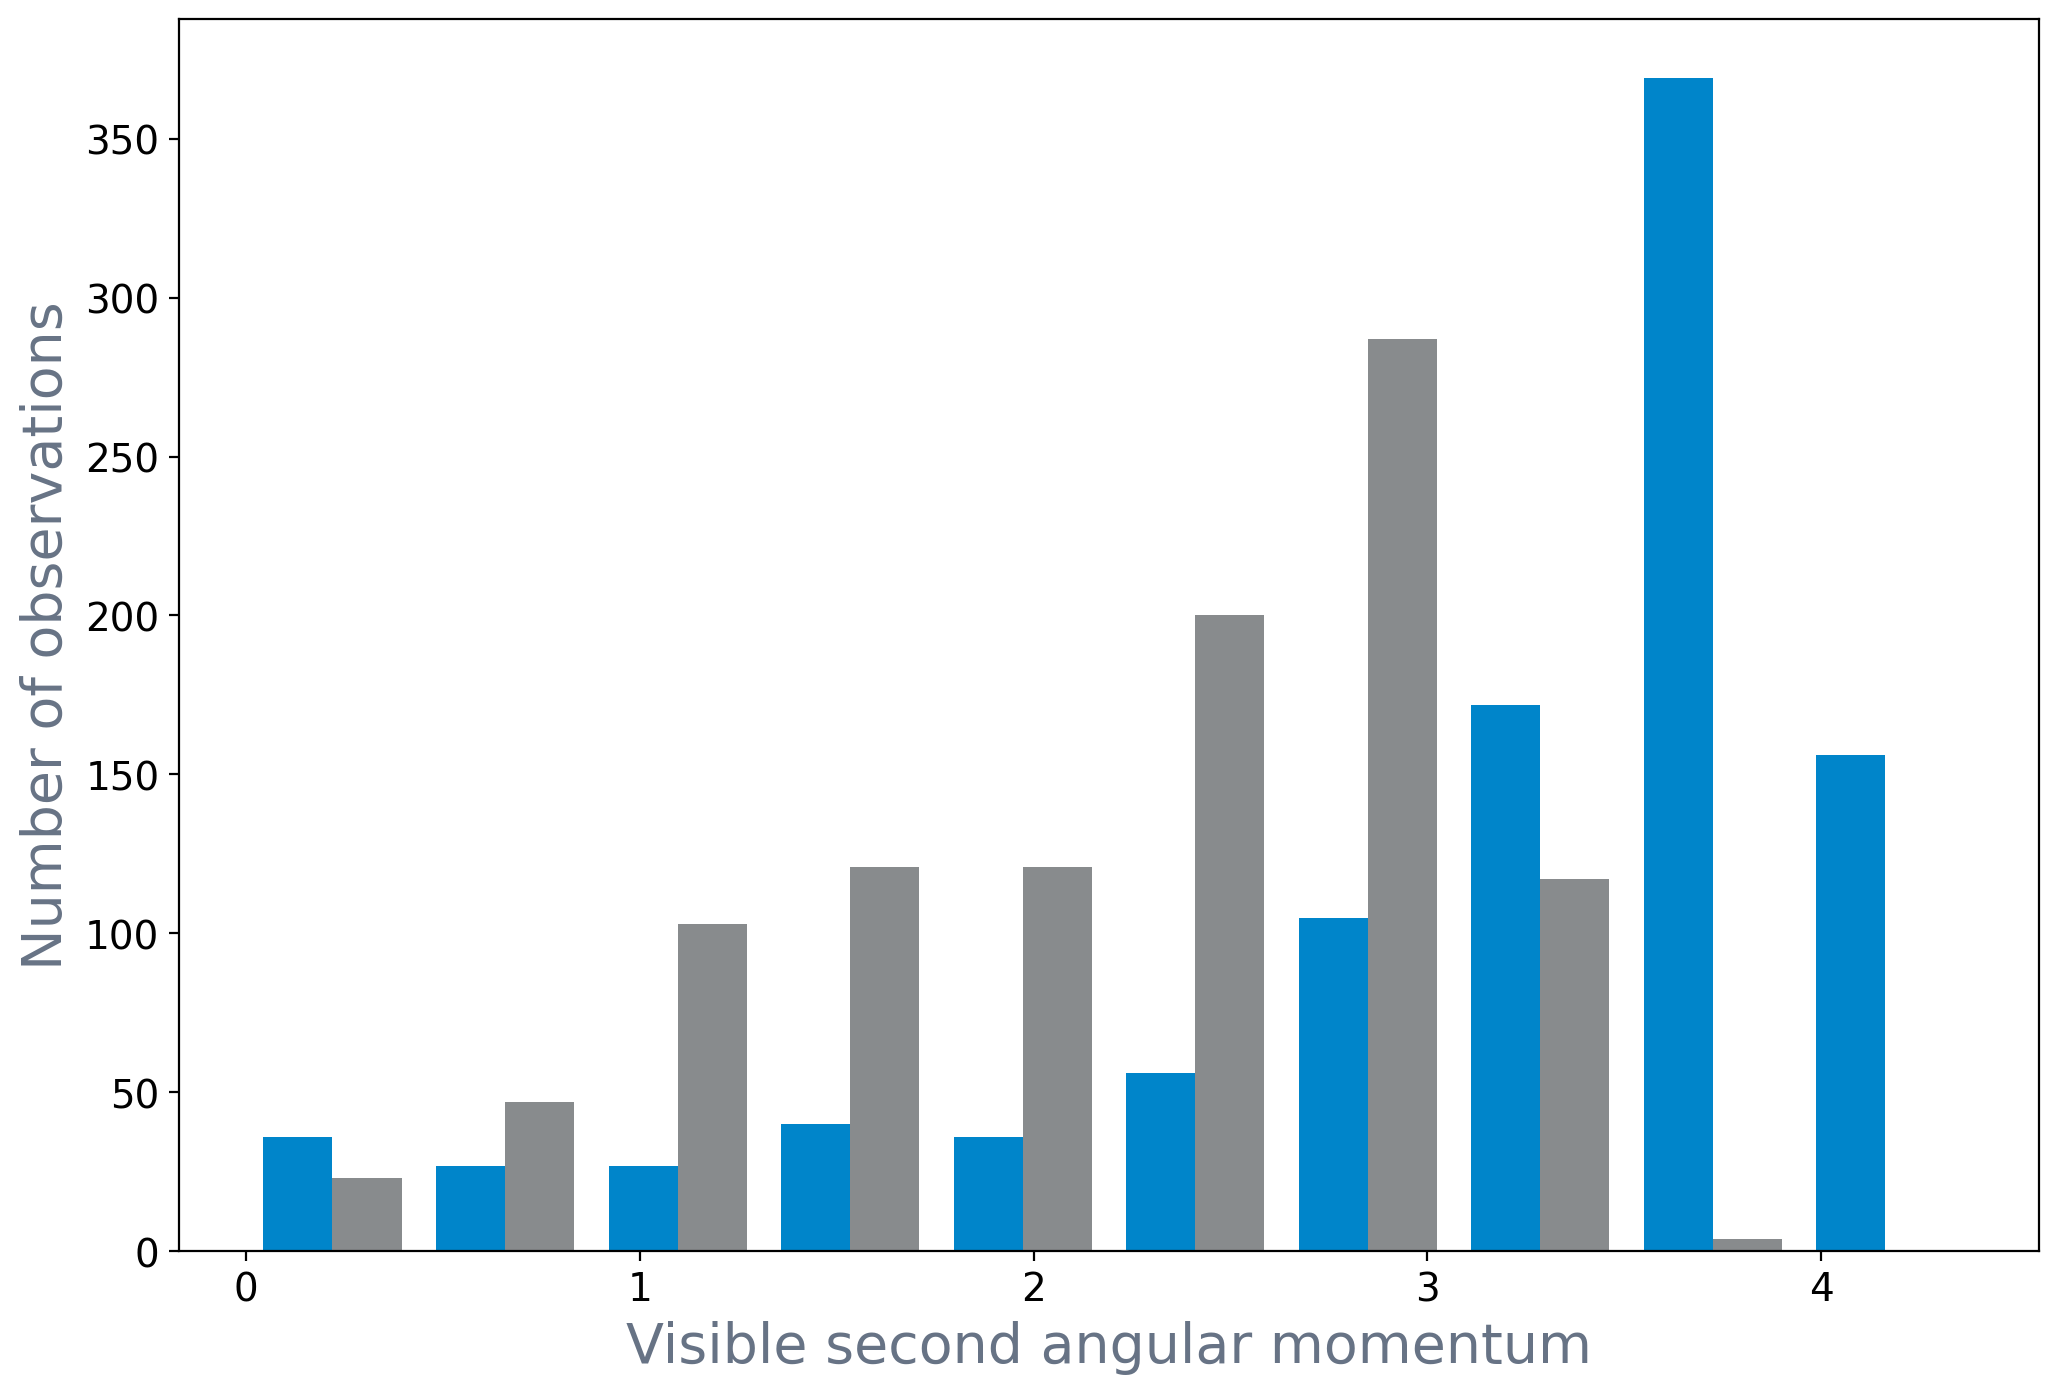

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

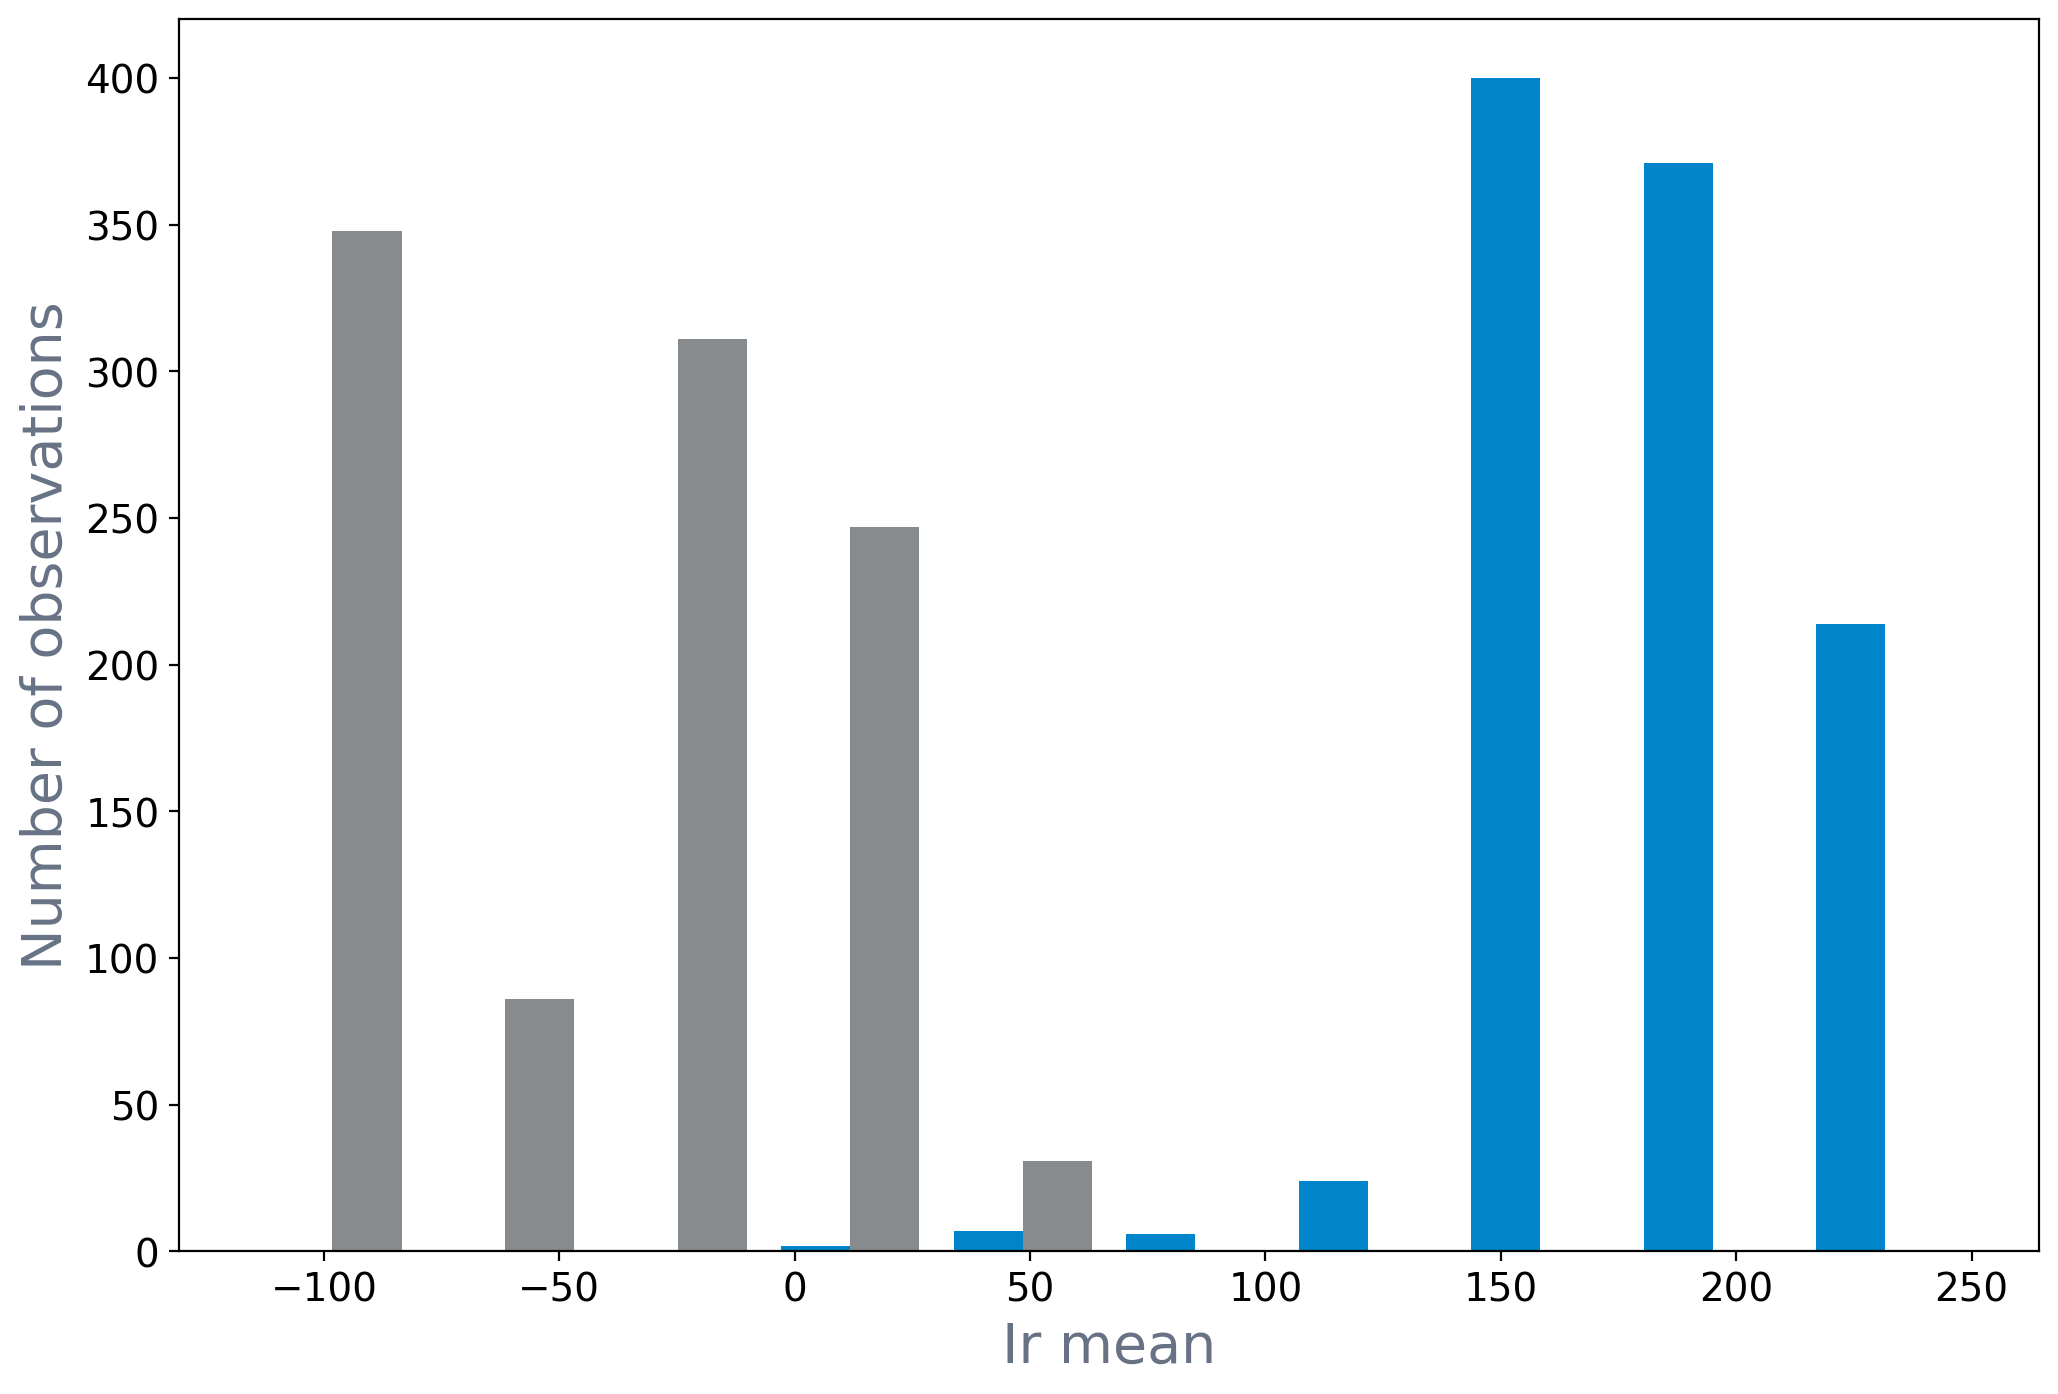

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

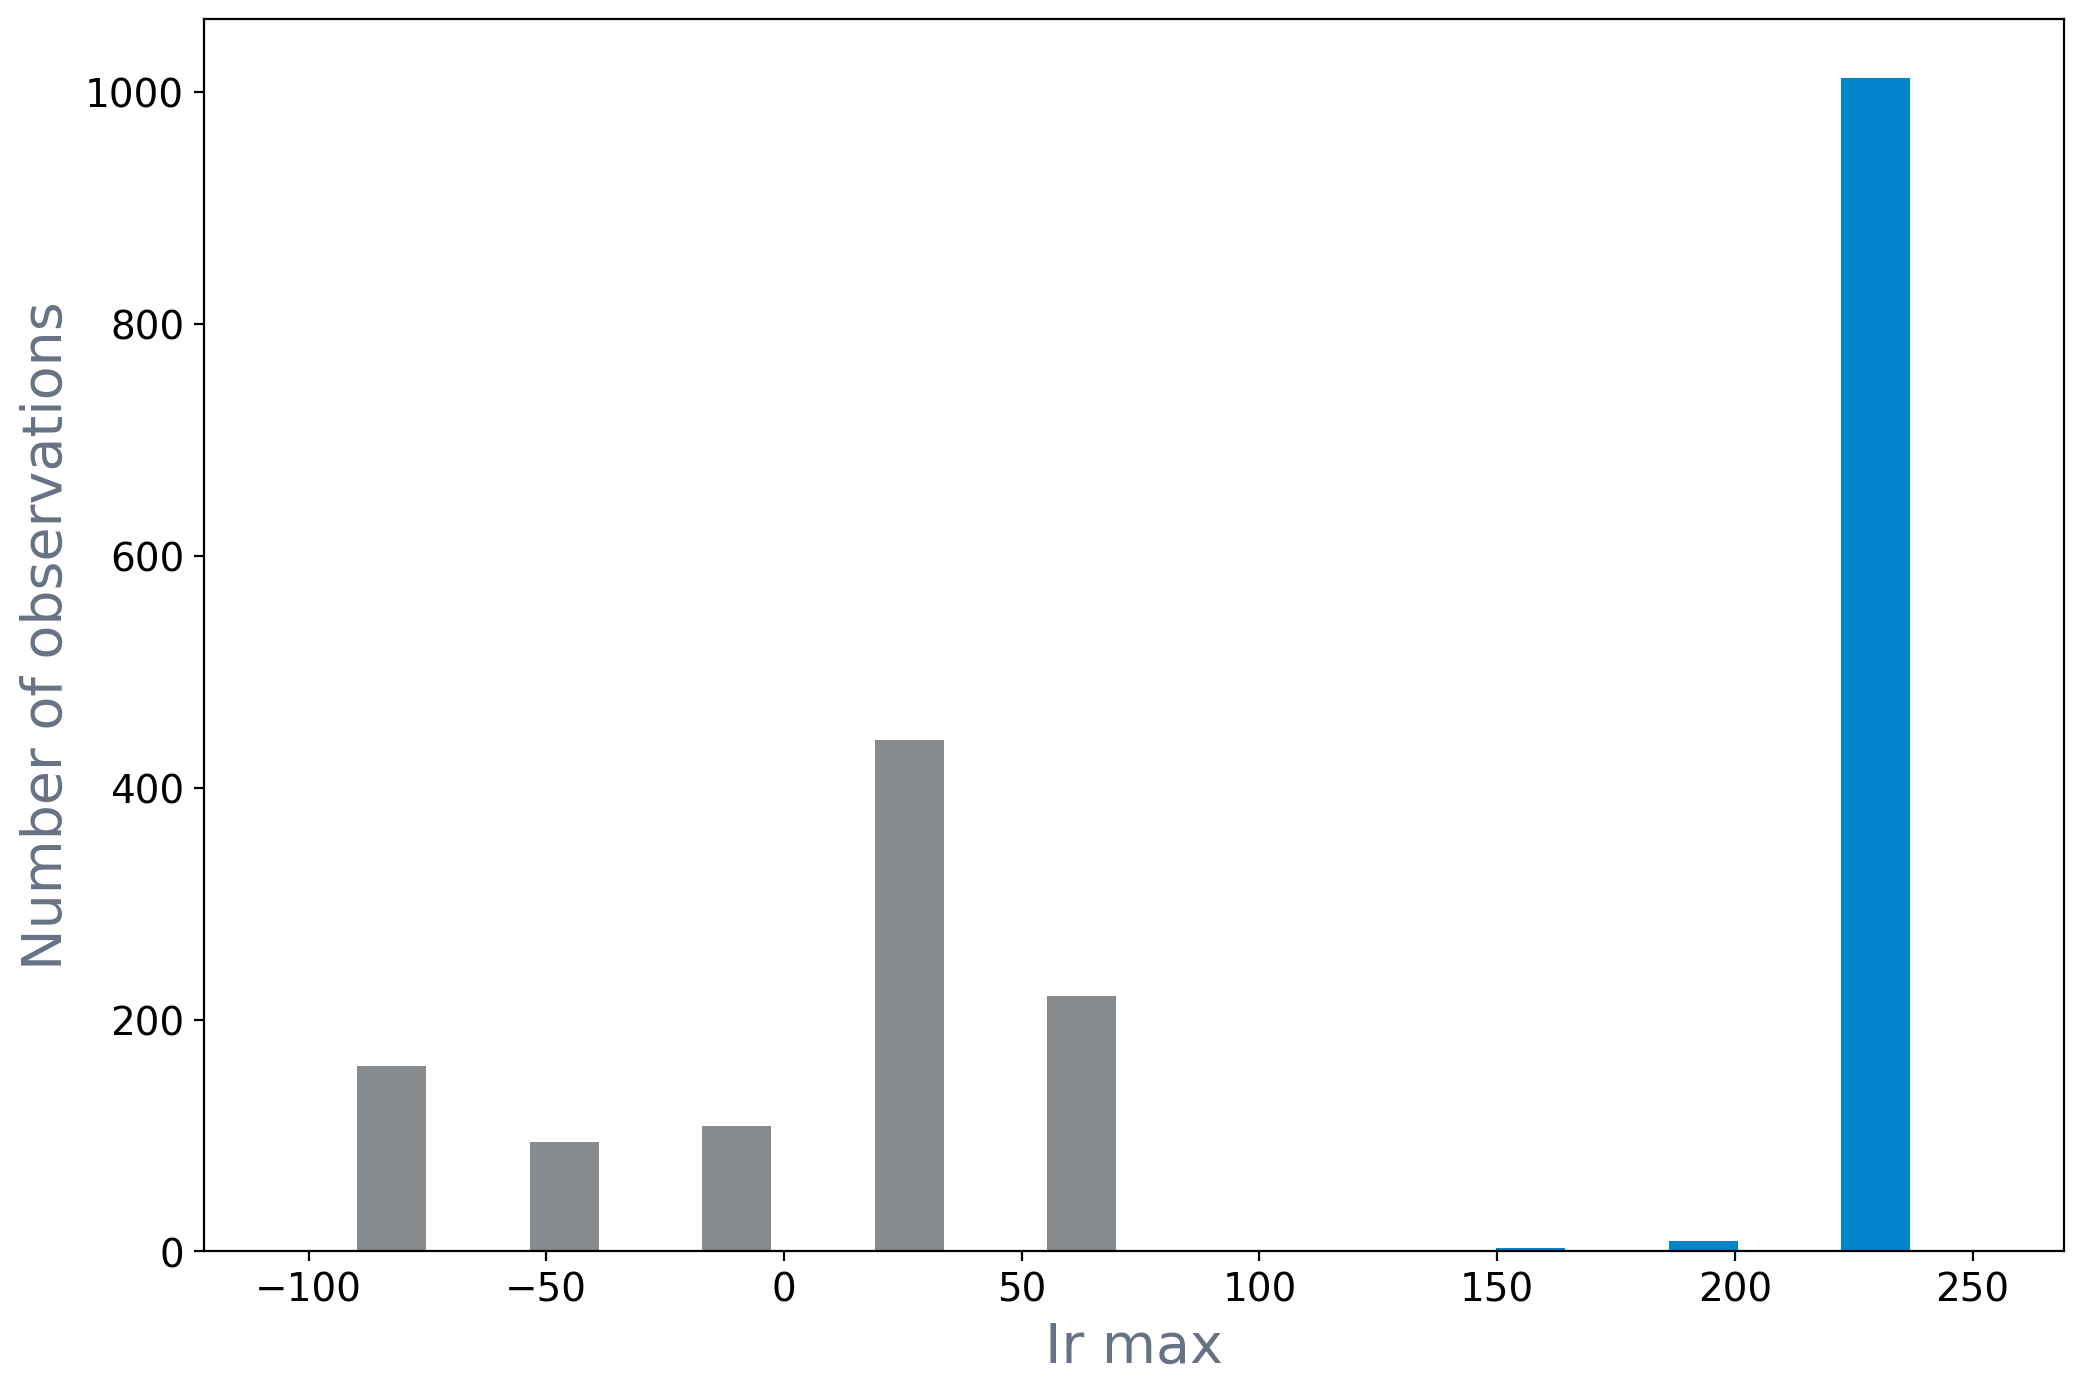

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

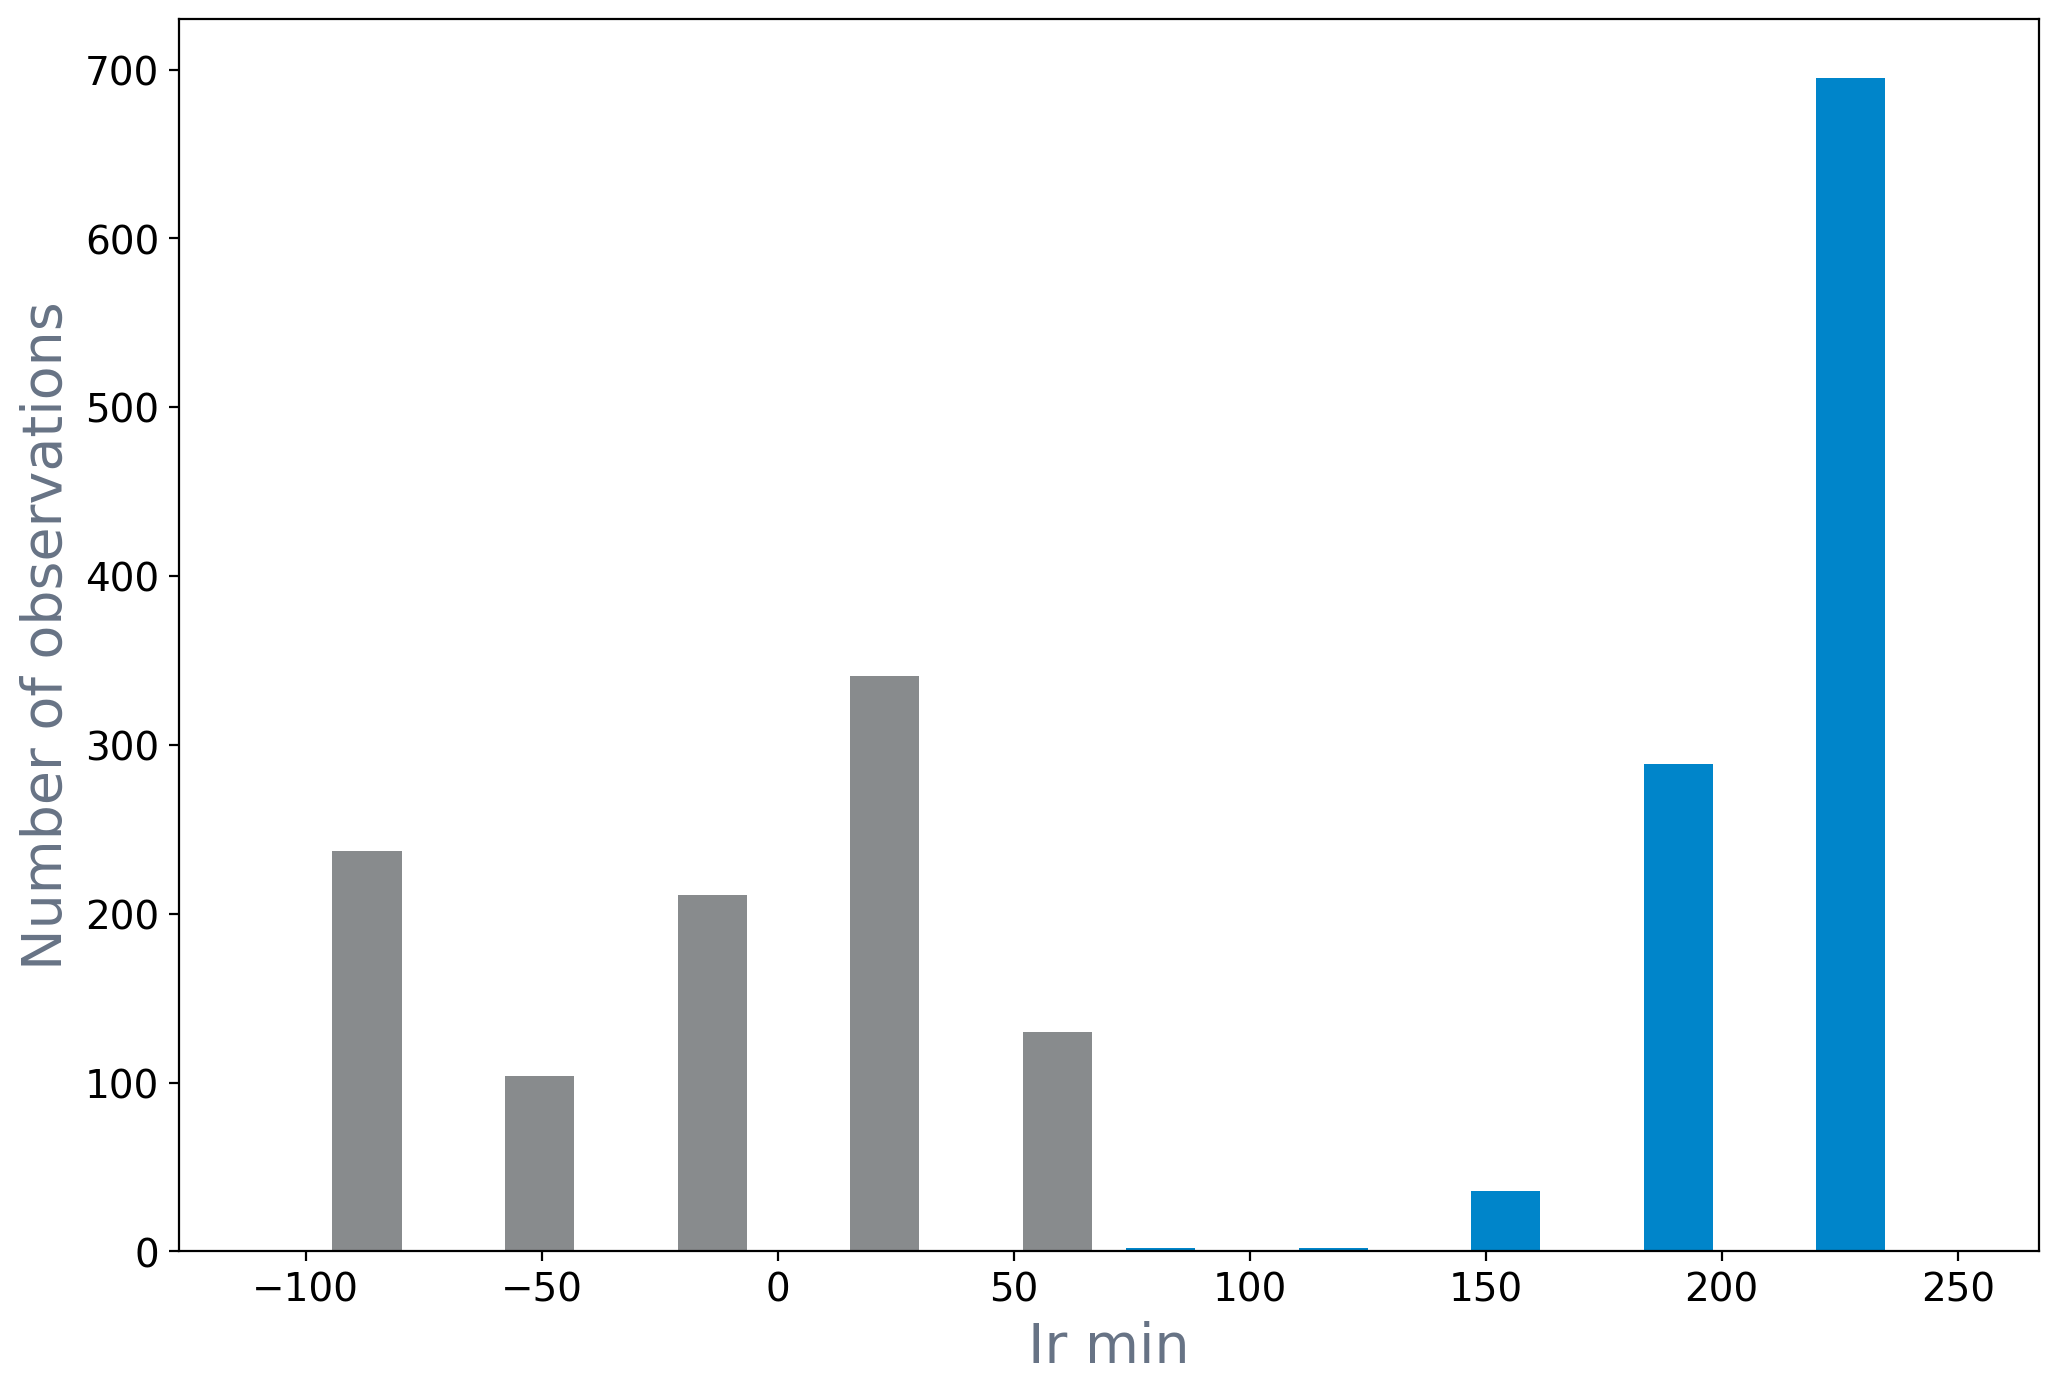

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

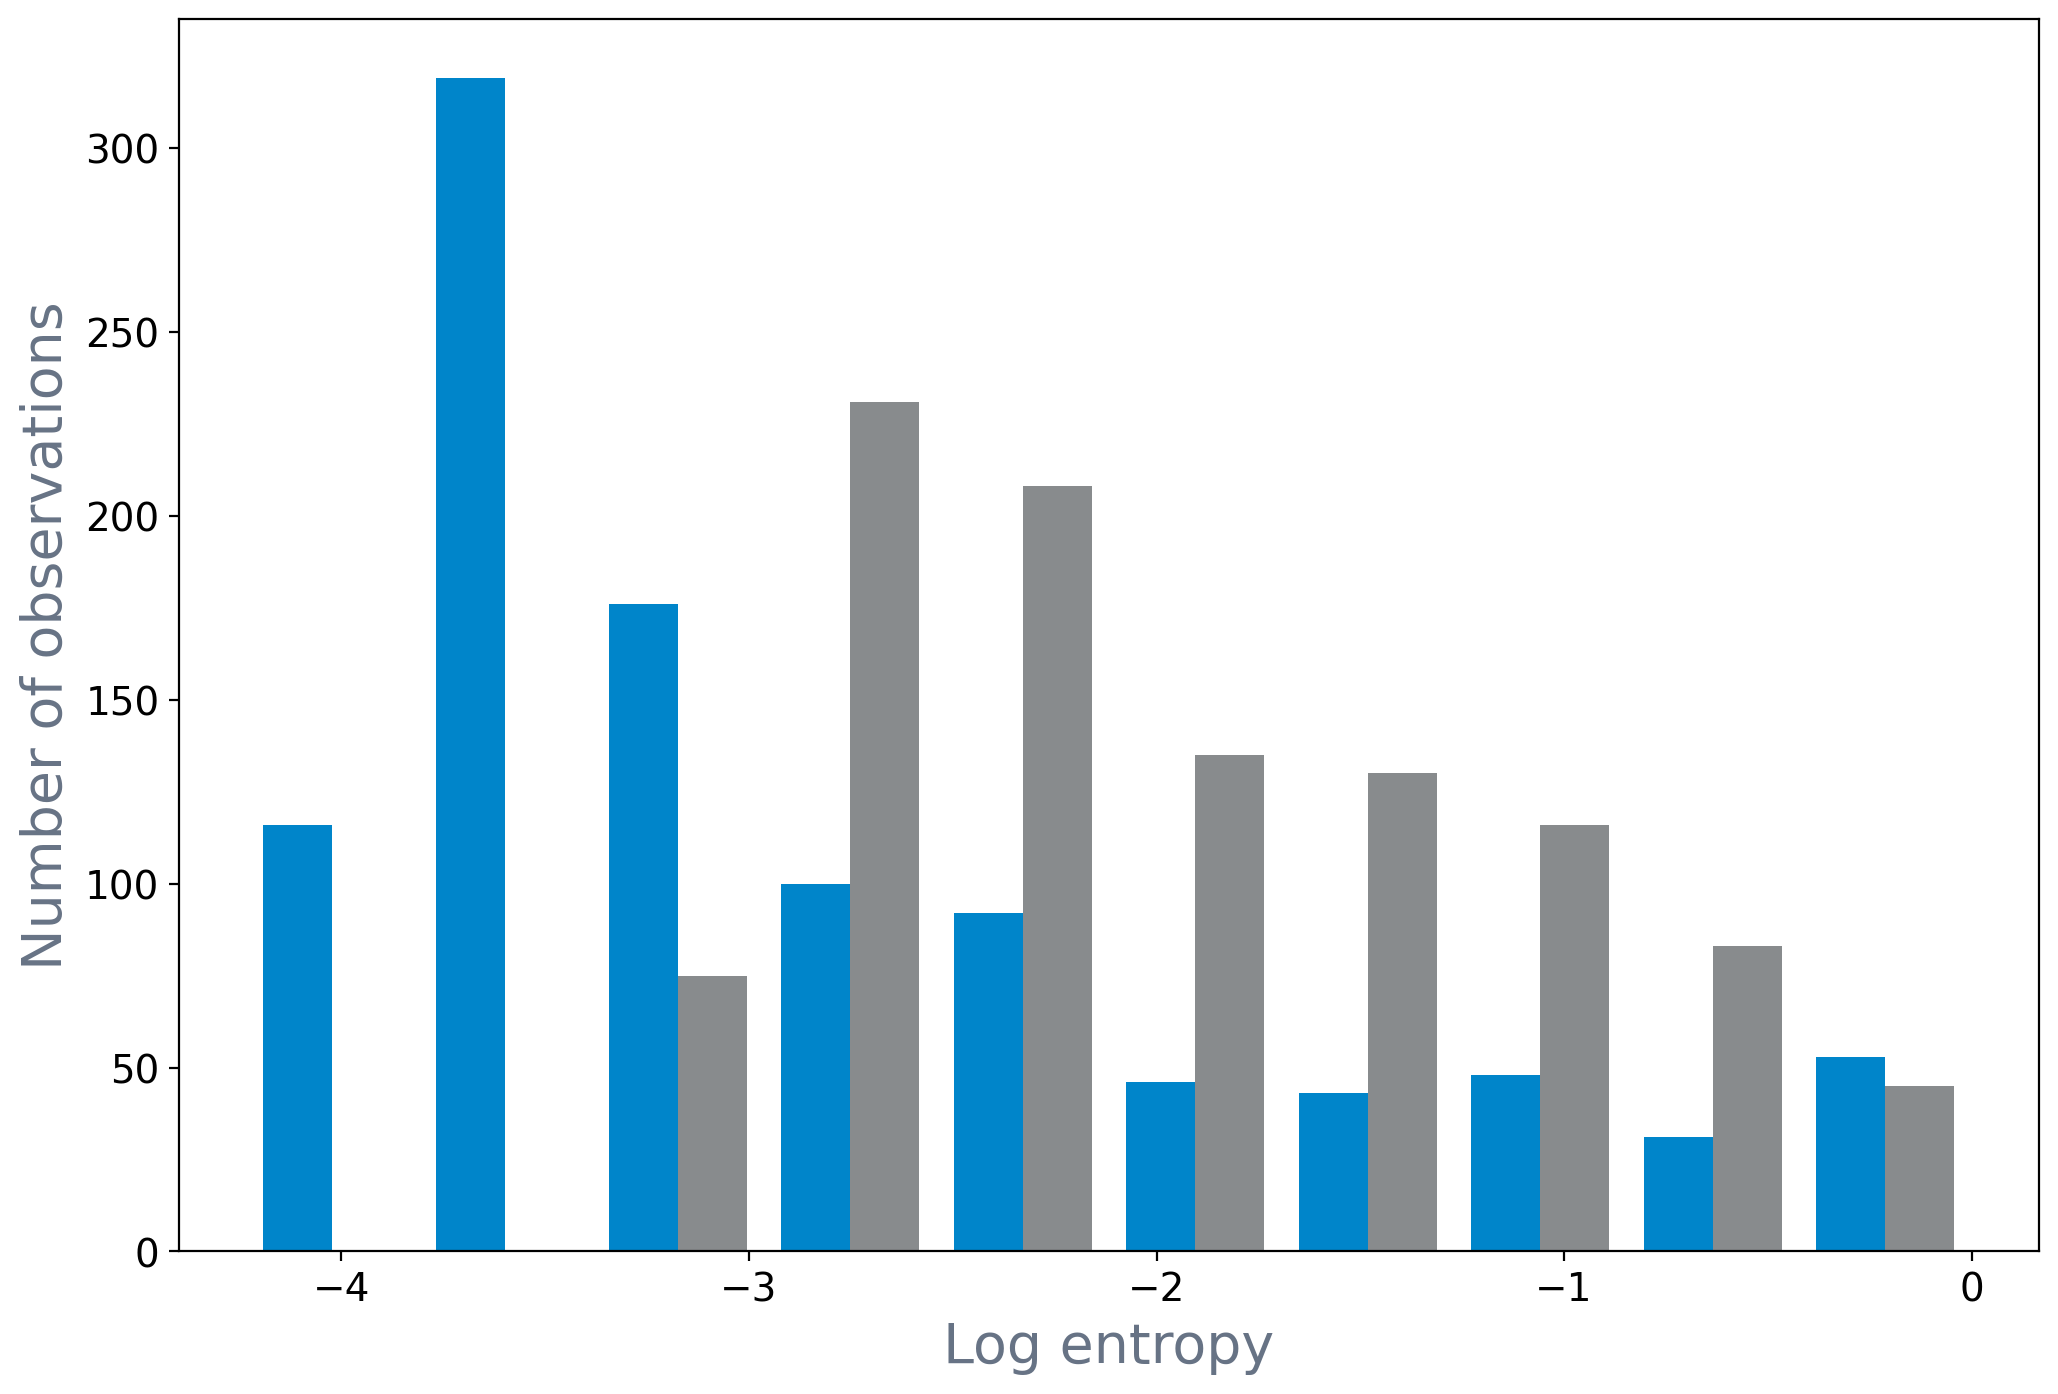

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

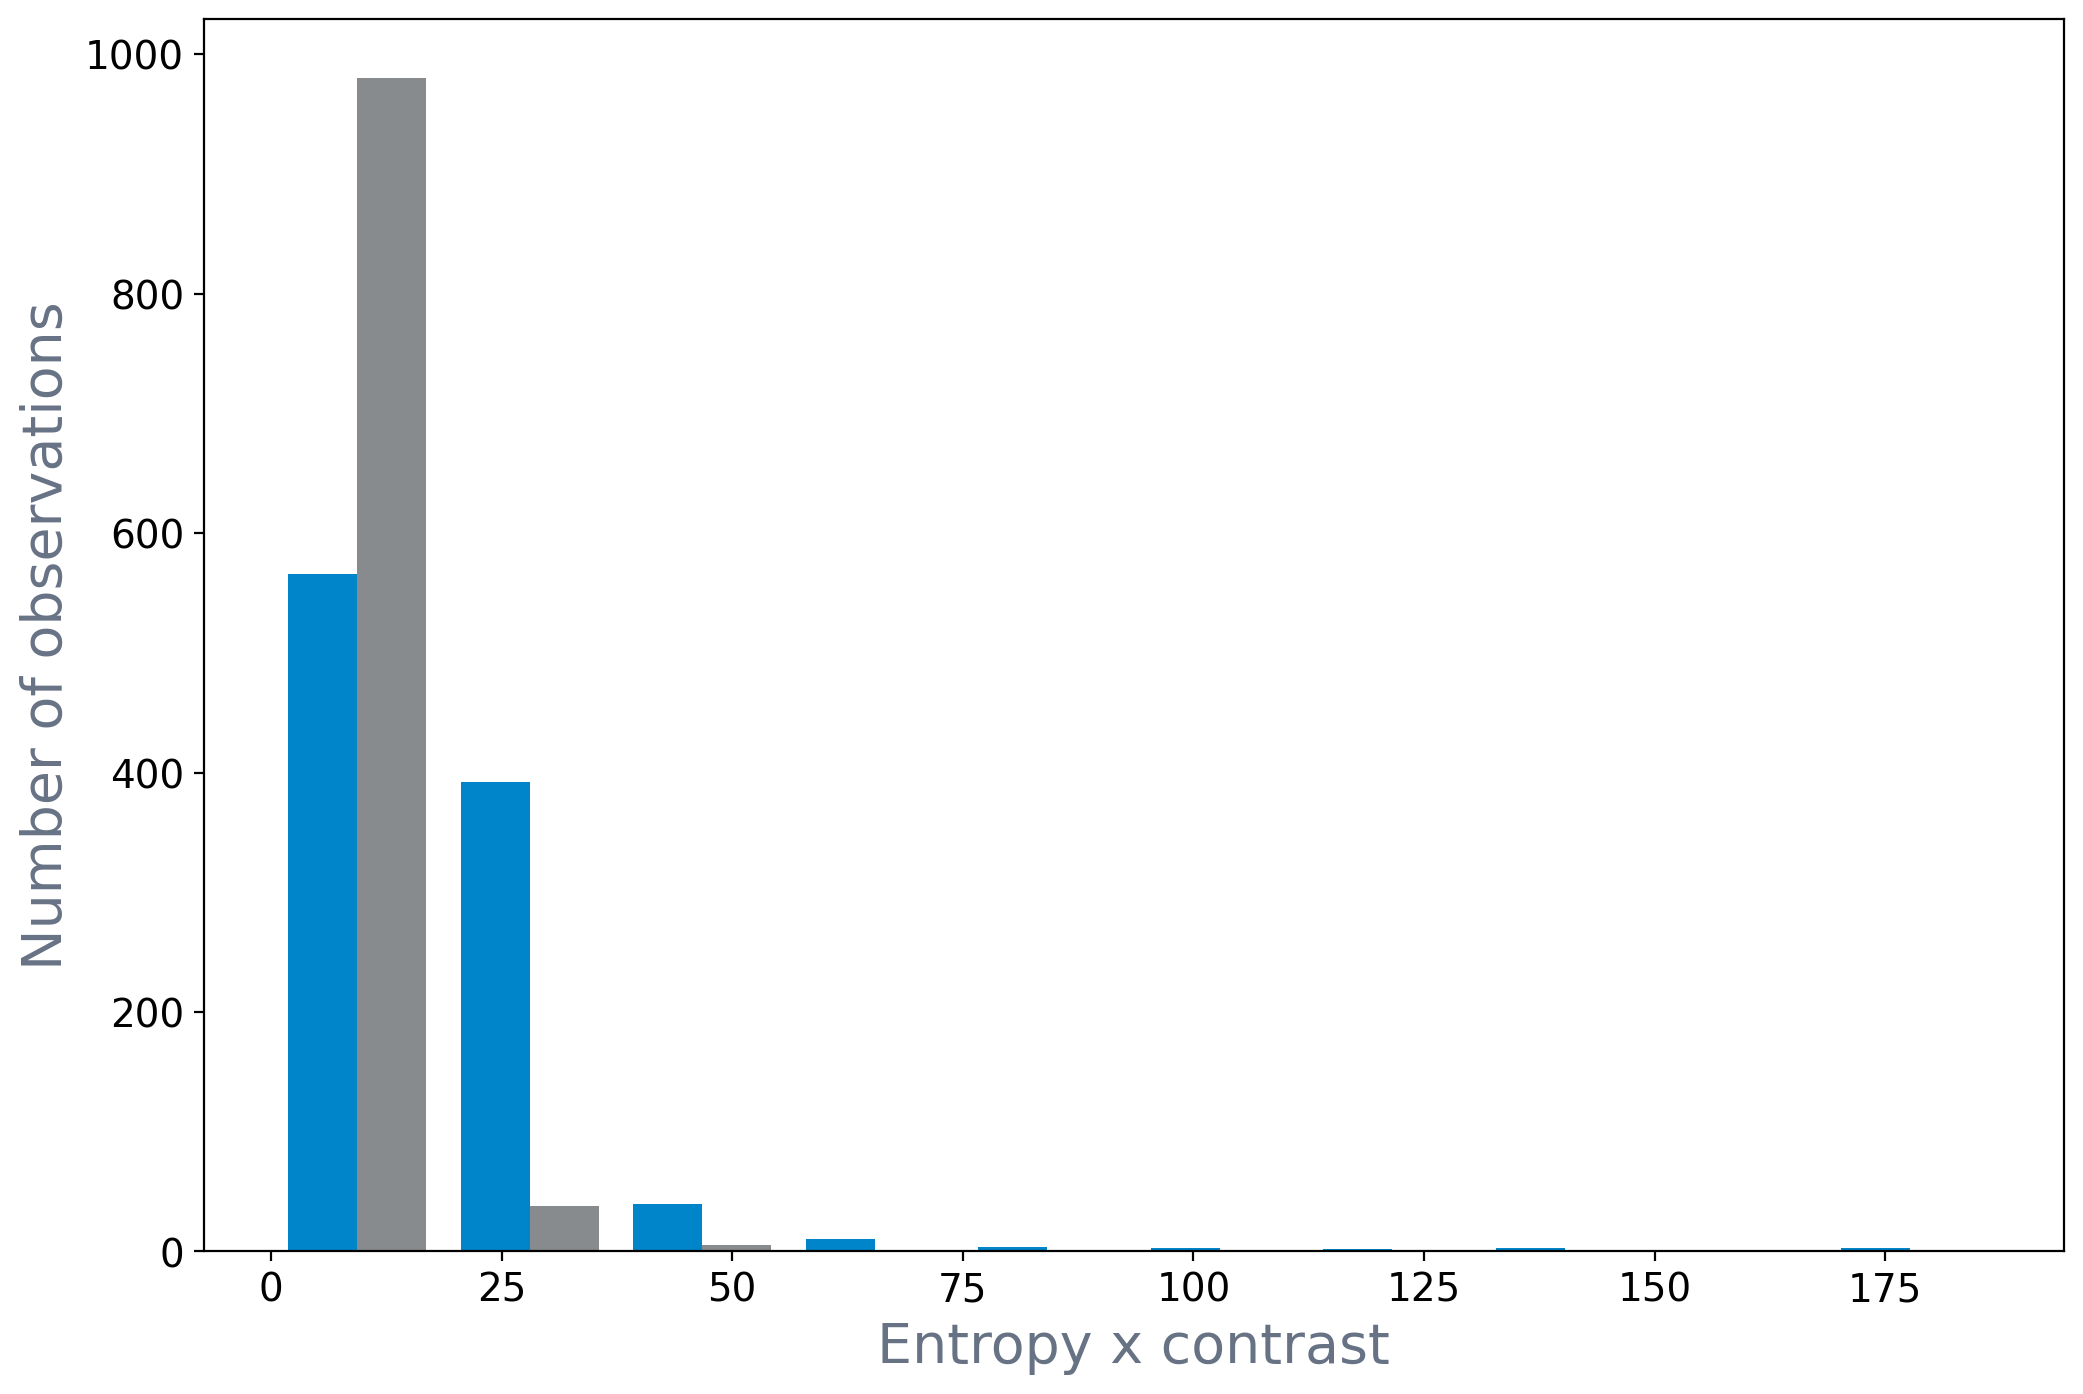

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

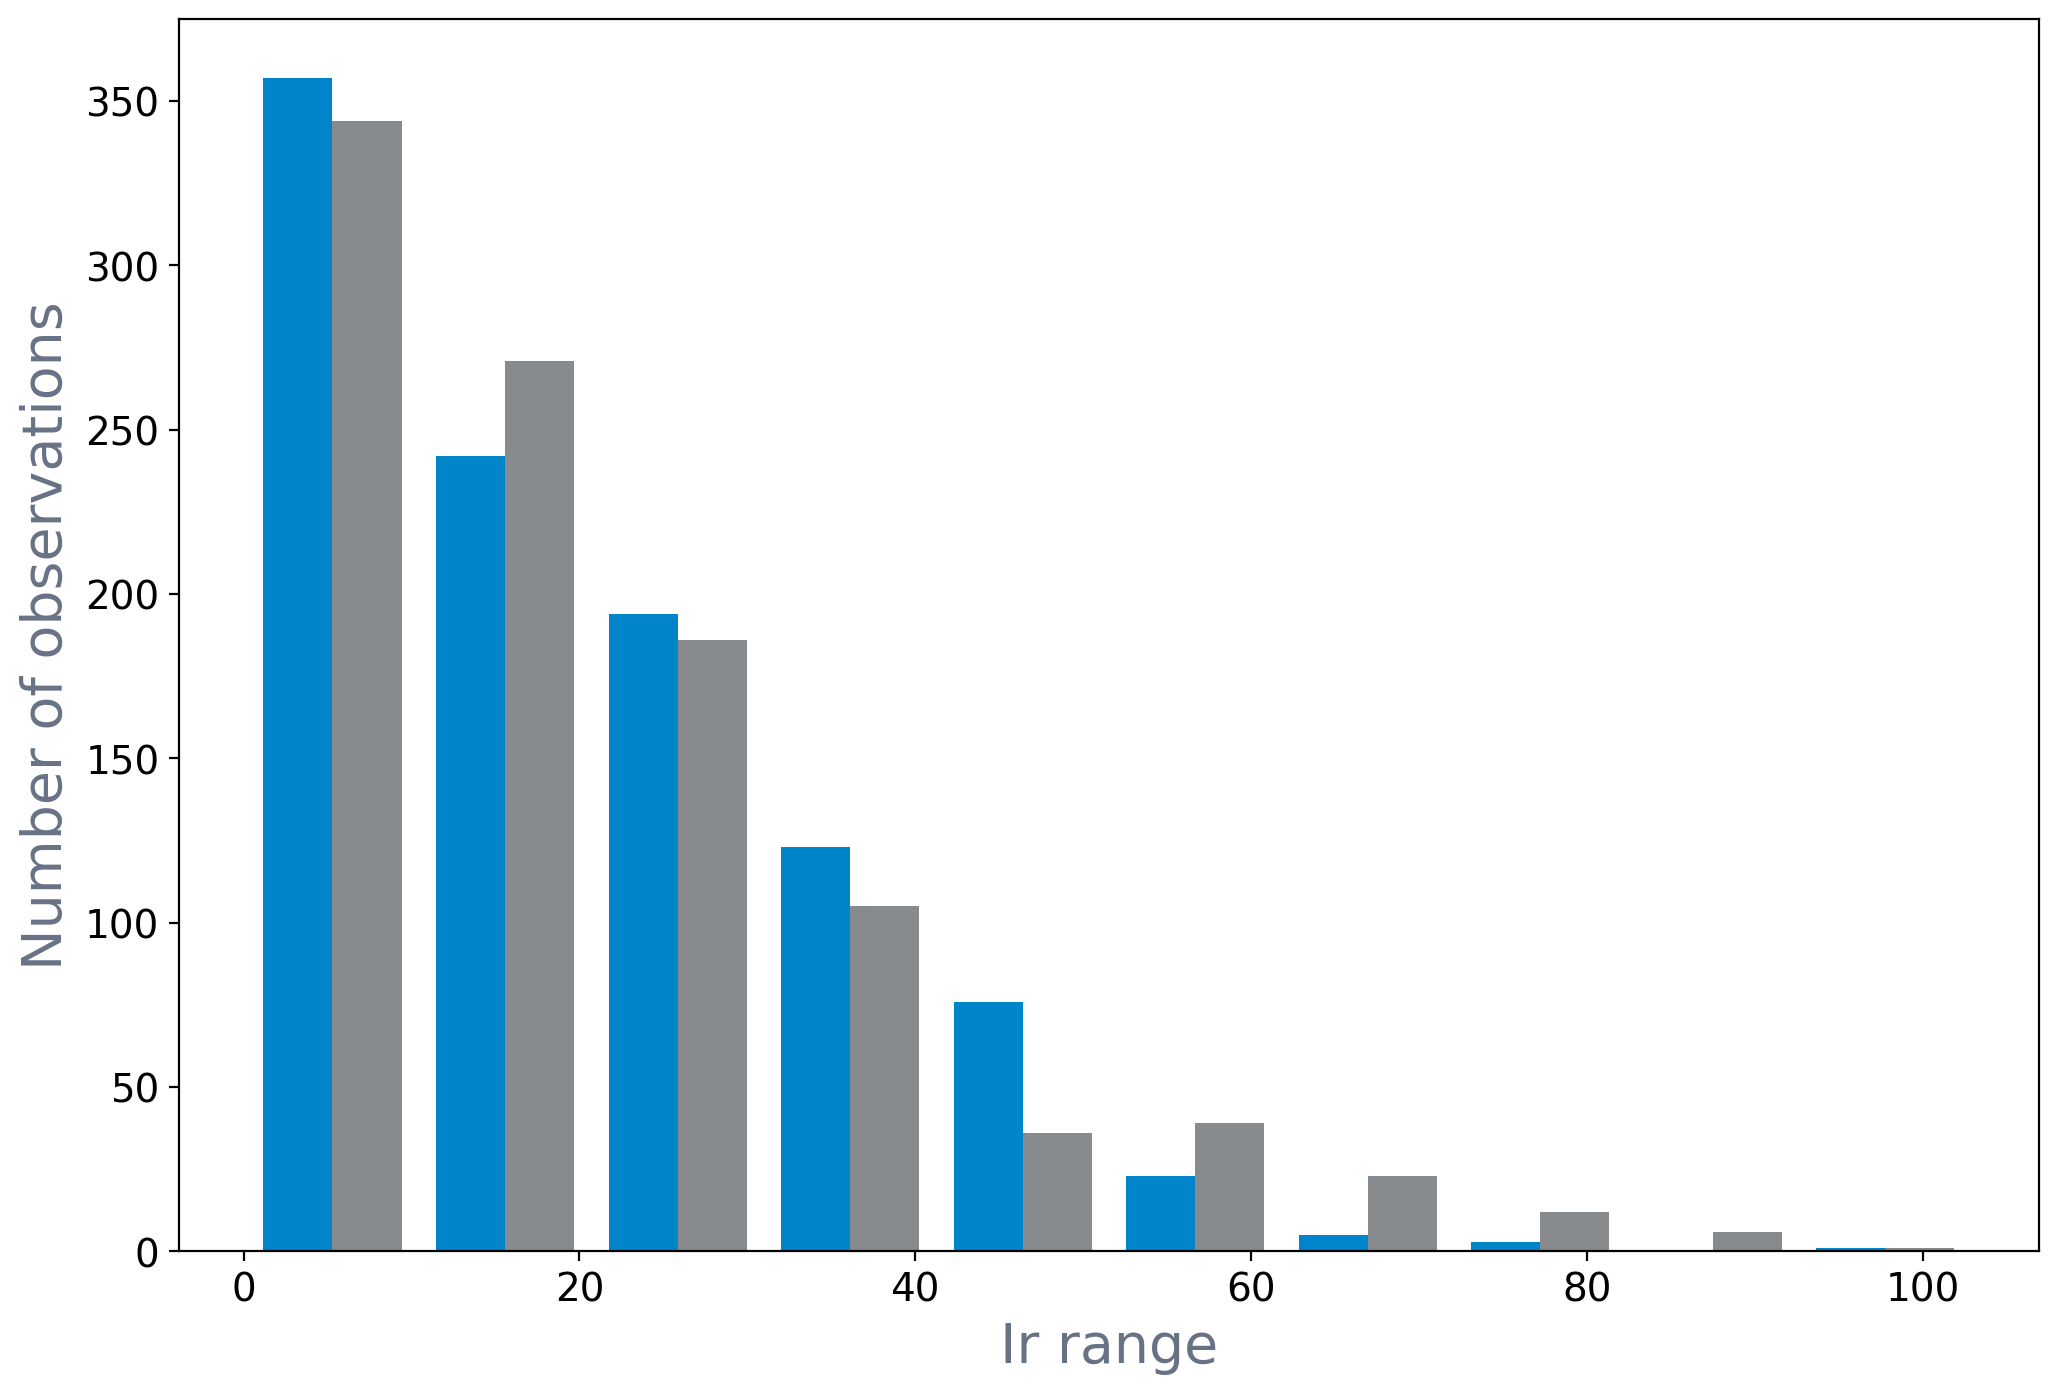

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

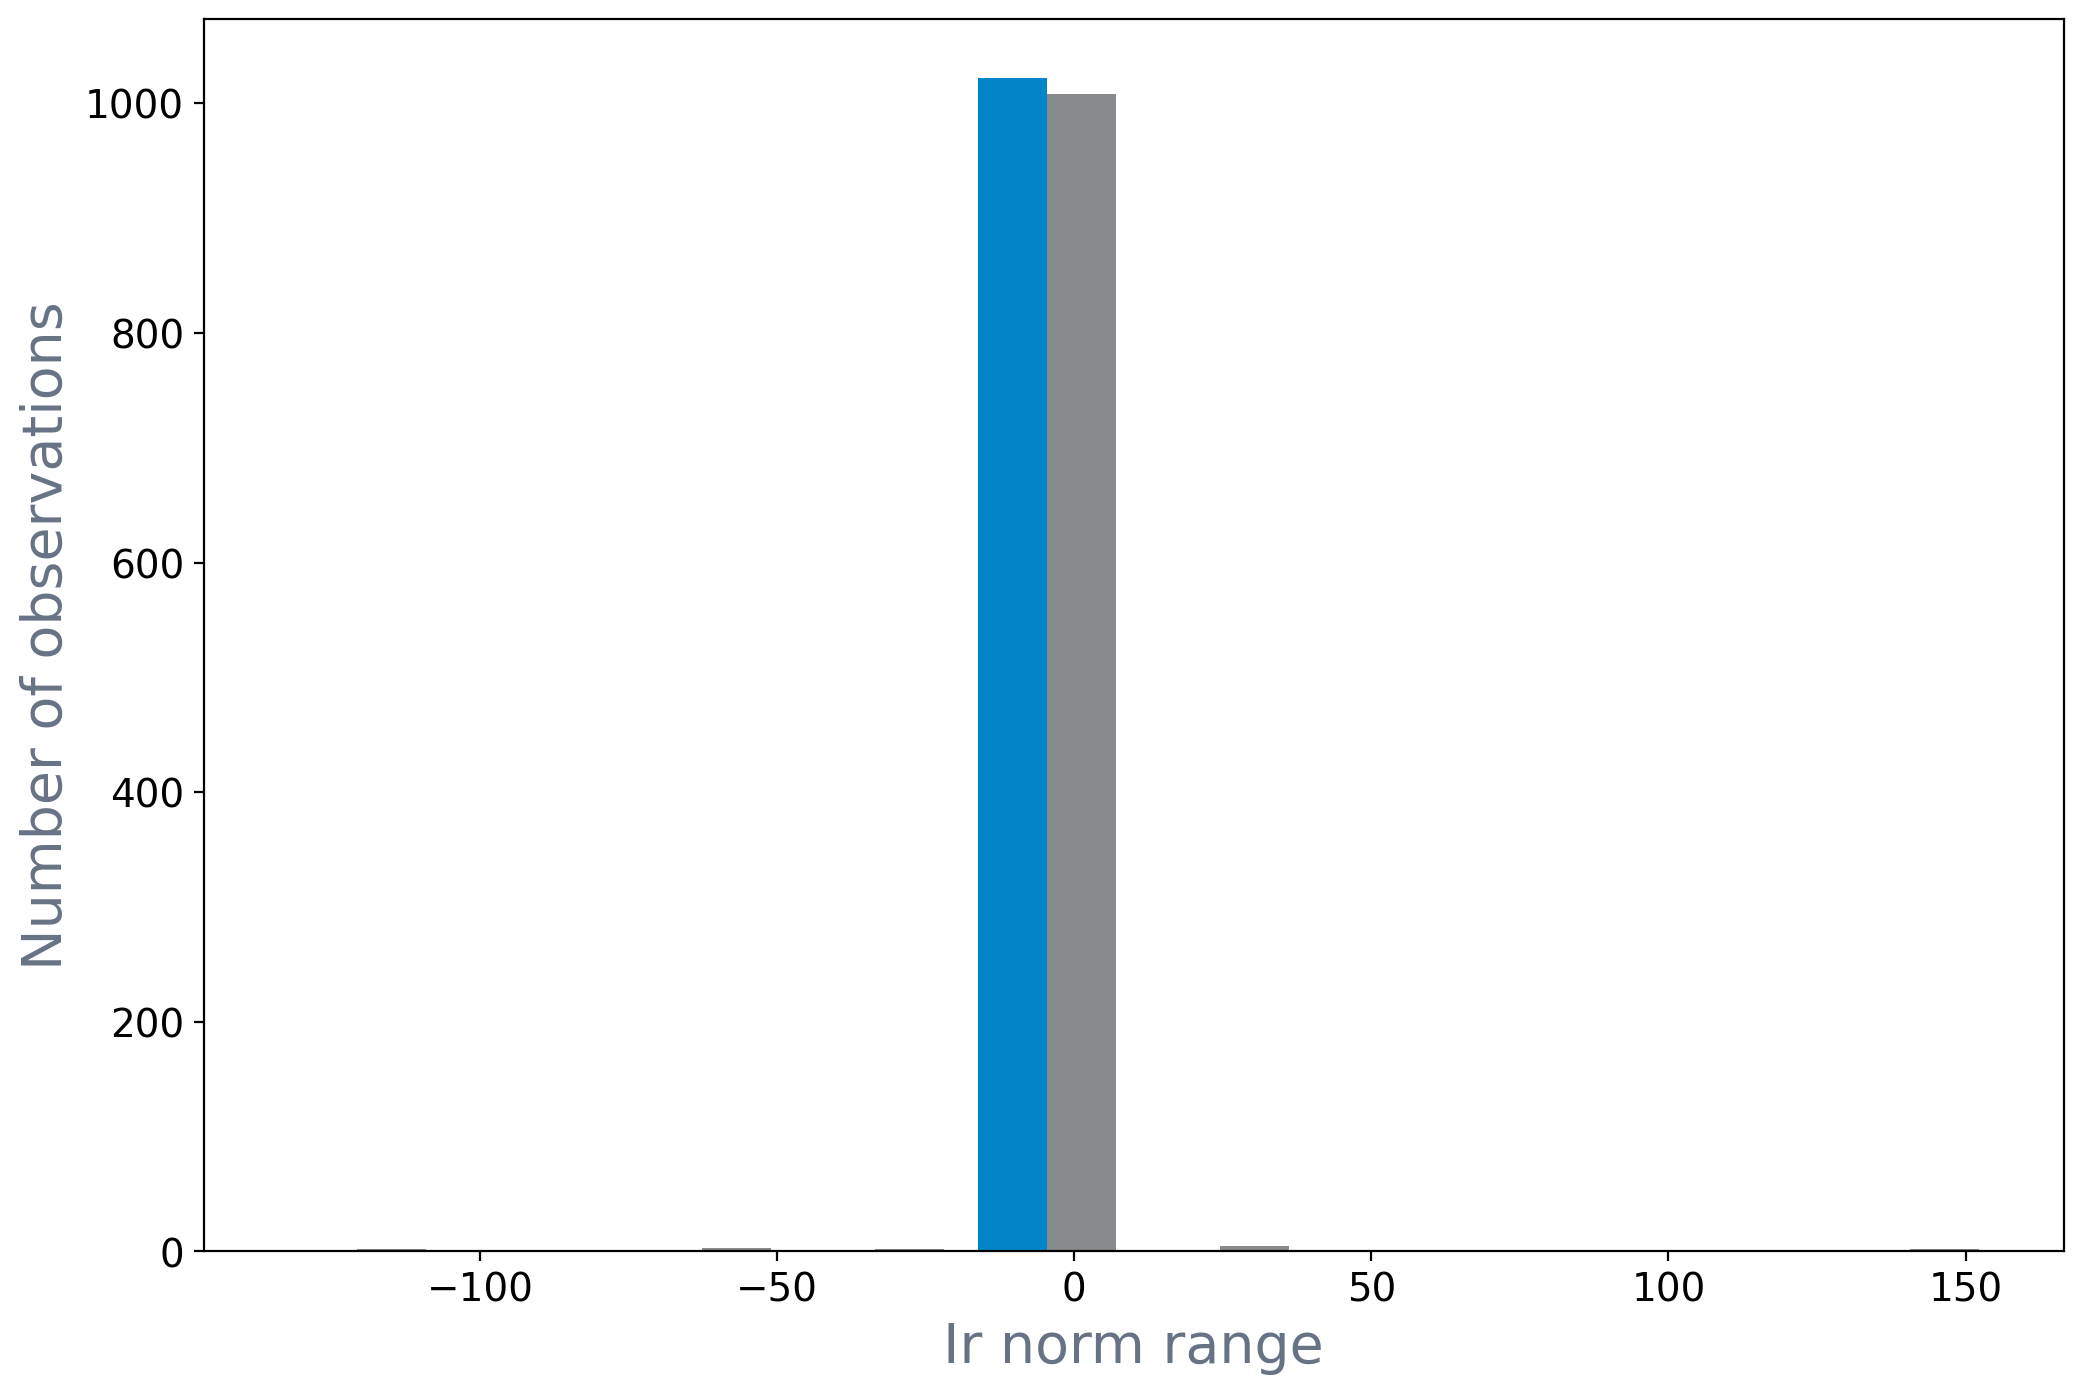

In [25]:
figs = []
for feat in features.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([
        features[target == 0][feat].values, features[target == 1][feat].values
    ])
    ax.set_xlabel(' '.join(feat.split('_')).capitalize())
    ax.set_ylabel('Number of observations')
    figs.append(fig)

## Split data into test and train

In [26]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, target, test_size=0.4)

# Train model

In [27]:
X_train

,visible_mean,visible_max,visible_min,visible_mean_distribution,visible_contrast,visible_entropy,visible_second_angular_momentum,IR_mean,IR_max,IR_min,log_entropy,entropy_x_contrast,IR_range,IR_norm_range
936,3.0000,105.0000,17.6289,0.0260,185.9583,0.1811,2.4602,207.0000,247.0000,240.5117,-1.708706,33.677048,6.4883,0.031344
354,4.7150,42.3368,11.0704,2.3375,16.3125,0.2358,1.9356,13.1275,34.4283,30.8414,-1.444771,3.846488,3.5869,0.273236
660,3.0000,30.0000,5.0273,0.0038,7.1375,0.5217,1.1414,234.0000,251.0000,248.9492,-0.650663,3.723634,2.0508,0.008764
226,6.8648,69.4246,25.8798,5.5958,62.1208,0.0836,2.7372,-18.8835,32.7164,15.8802,-2.481712,5.193299,16.8362,-0.891583
940,2.0000,4.0000,2.8477,0.0006,0.1500,0.7450,0.4227,245.0000,247.0000,246.3633,-0.294371,0.111750,0.6367,0.002599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,54.3758,132.4143,89.3902,8.6500,129.4667,0.0538,3.0893,-16.3644,7.3674,-8.0974,-2.922482,6.965308,15.4648,-0.945027
283,7.0000,120.0000,37.2461,0.0545,400.5667,0.0418,3.5280,179.0000,239.0000,221.7539,-3.174859,16.743688,17.2461,0.096347
368,4.0000,155.0000,35.7617,0.0653,568.9292,0.0379,3.6201,180.0000,242.0000,224.9883,-3.272804,21.562417,17.0117,0.094509
613,4.0700,126.6098,37.9843,10.5417,266.5833,0.1190,2.9747,-7.6951,39.0675,23.9309,-2.128632,31.723413,15.1366,-1.967044


In [28]:
train = X_train
train['class'] = y_train
train

,visible_mean,visible_max,visible_min,visible_mean_distribution,visible_contrast,visible_entropy,visible_second_angular_momentum,IR_mean,IR_max,IR_min,log_entropy,entropy_x_contrast,IR_range,IR_norm_range,class
936,3.0000,105.0000,17.6289,0.0260,185.9583,0.1811,2.4602,207.0000,247.0000,240.5117,-1.708706,33.677048,6.4883,0.031344,0.0
354,4.7150,42.3368,11.0704,2.3375,16.3125,0.2358,1.9356,13.1275,34.4283,30.8414,-1.444771,3.846488,3.5869,0.273236,1.0
660,3.0000,30.0000,5.0273,0.0038,7.1375,0.5217,1.1414,234.0000,251.0000,248.9492,-0.650663,3.723634,2.0508,0.008764,0.0
226,6.8648,69.4246,25.8798,5.5958,62.1208,0.0836,2.7372,-18.8835,32.7164,15.8802,-2.481712,5.193299,16.8362,-0.891583,1.0
940,2.0000,4.0000,2.8477,0.0006,0.1500,0.7450,0.4227,245.0000,247.0000,246.3633,-0.294371,0.111750,0.6367,0.002599,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,54.3758,132.4143,89.3902,8.6500,129.4667,0.0538,3.0893,-16.3644,7.3674,-8.0974,-2.922482,6.965308,15.4648,-0.945027,1.0
283,7.0000,120.0000,37.2461,0.0545,400.5667,0.0418,3.5280,179.0000,239.0000,221.7539,-3.174859,16.743688,17.2461,0.096347,0.0
368,4.0000,155.0000,35.7617,0.0653,568.9292,0.0379,3.6201,180.0000,242.0000,224.9883,-3.272804,21.562417,17.0117,0.094509,0.0
613,4.0700,126.6098,37.9843,10.5417,266.5833,0.1190,2.9747,-7.6951,39.0675,23.9309,-2.128632,31.723413,15.1366,-1.967044,1.0


In [29]:
initial_features = ['log_entropy', 'IR_norm_range', 'entropy_x_contrast']

In [30]:
svc = sklearn.svm.SVC()

In [31]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)

In [32]:
rf.fit(X_train[initial_features], y_train)

RandomForestClassifier(max_depth=10, n_estimators=10)

In [33]:
svc.fit(X_train[initial_features], y_train)

SVC()

In [36]:
import pickle

with open("model_v1.pkl", "wb") as file:
    pickle.dump(svc, file)

In [94]:
dir(rf)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight'

In [95]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [96]:
isinstance(rf, sklearn.ensemble._forest.RandomForestClassifier)

True

In [97]:
attributes = dict()
for modelatt in dir(rf):
    try:
        att_val = getattr(rf, modelatt)
        print(modelatt, ': ', type(att_val), )
        attributes[modelatt] = att_val
    except:
        print('error', modelatt)

__abstractmethods__ :  <class 'frozenset'>
__annotations__ :  <class 'dict'>
__class__ :  <class 'abc.ABCMeta'>
__delattr__ :  <class 'method-wrapper'>
__dict__ :  <class 'dict'>
__dir__ :  <class 'builtin_function_or_method'>
__doc__ :  <class 'str'>
__eq__ :  <class 'method-wrapper'>
__format__ :  <class 'builtin_function_or_method'>
__ge__ :  <class 'method-wrapper'>
__getattribute__ :  <class 'method-wrapper'>
__getitem__ :  <class 'method'>
__getstate__ :  <class 'method'>
__gt__ :  <class 'method-wrapper'>
__hash__ :  <class 'method-wrapper'>
__init__ :  <class 'method'>
__init_subclass__ :  <class 'builtin_function_or_method'>
__iter__ :  <class 'method'>
__le__ :  <class 'method-wrapper'>
__len__ :  <class 'method'>
__lt__ :  <class 'method-wrapper'>
__module__ :  <class 'str'>
__ne__ :  <class 'method-wrapper'>
__new__ :  <class 'builtin_function_or_method'>
__reduce__ :  <class 'builtin_function_or_method'>
__reduce_ex__ :  <class 'builtin_function_or_method'>
__repr__ :  <cl

# Score model

In [98]:
X_train

,visible_mean,visible_max,visible_min,visible_mean_distribution,visible_contrast,visible_entropy,visible_second_angular_momentum,IR_mean,IR_max,IR_min,log_entropy,entropy_x_contrast,IR_range,IR_norm_range,class
196,19.0000,157.0000,72.3438,0.0539,328.5458,0.0359,3.5149,132.0000,224.0000,179.5234,-3.327018,11.794794,44.4766,0.336944,0.0
1022,6.0000,103.0000,18.2500,0.0216,89.4375,0.0992,2.6809,218.0000,246.0000,240.3438,-2.310617,8.872200,5.6562,0.025946,0.0
178,14.3891,64.2650,43.6695,4.2875,30.9708,0.1009,2.4528,-7.1672,25.9487,3.2421,-2.293625,3.124954,22.7066,-3.168127,1.0
420,8.0000,190.0000,75.4492,0.1282,1754.7539,0.0180,4.1666,166.0000,239.0000,203.5781,-4.017384,31.585570,35.4219,0.213385,0.0
678,4.0700,131.5544,13.8735,3.4667,78.4583,0.3775,1.7417,-3.2572,41.7633,36.9408,-0.974185,29.618008,4.8225,-1.480566,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,7.5097,60.8253,27.4829,5.9458,64.3208,0.0754,2.7812,-81.4919,28.5944,-24.2417,-2.584948,4.849788,52.8361,-0.648360,1.0
317,58.4605,88.3430,70.0670,1.1375,3.7042,0.3155,1.4555,-103.0842,-80.6227,-94.7347,-1.153597,1.168675,14.1120,-0.136898,1.0
867,1.0000,15.0000,3.8516,0.0060,7.4417,0.3213,1.6072,240.0000,250.0000,248.0430,-1.135380,2.391018,1.9570,0.008154,0.0
944,2.0000,4.0000,2.3164,0.0009,0.2250,0.6513,0.5332,248.0000,250.0000,249.6758,-0.428785,0.146542,0.3242,0.001307,0.0


In [99]:
ypred_proba_test = rf.predict_proba(X_test[initial_features])[:,1]
ypred_bin_test = rf.predict(X_test[initial_features])

In [103]:
ypred_proba_test

array([1.        , 1.        , 1.        , 0.99      , 0.1       ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.9       , 0.        , 0.        ,
       0.8       , 1.        , 0.03636364, 1.        , 1.        ,
       1.        , 0.8       , 1.        , 0.80793651, 0.        ,
       0.        , 1.        , 0.00793651, 1.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.00793651, 1.        , 1.        , 1.        ,
       0.2       , 1.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.1       , 0.        , 0.8       ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 0.5       , 0.        , 1.        , 1.     

In [102]:
ypred_bin_test

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 1.

# Evaluate performance

In [35]:
auc = sklearn.metrics.roc_auc_score(y_test, ypred_proba_test)
confusion = sklearn.metrics.confusion_matrix(y_test, ypred_bin_test)
accuracy = sklearn.metrics.accuracy_score(y_test, ypred_bin_test)
classification_report = sklearn.metrics.classification_report(y_test, ypred_bin_test)

In [36]:
print('AUC on test: %0.3f' % auc)
print('Accuracy on test: %0.3f' % accuracy)
print()
print(pd.DataFrame(confusion,
                  index=['Actual negative','Actual positive'],
                  columns=['Predicted negative', 'Predicted positive']))

AUC on test: 1.000
Accuracy on test: 0.995

                 Predicted negative  Predicted positive
Actual negative                 407                   1
Actual positive                   3                 408


# Key findings
A classifier with very high accuracy has been developed that is ready for production. 


# Next steps
Move model over to scripts for productionalization

# Appendix

## Watermark 
For full reproducibility of results, use exact data extraction as defined at top of notebook and ensure that the environment is exactly as follows: 

In [37]:
# ! pip install watermark
%load_ext watermark
%watermark -v -m --iversions -g

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 8.12.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 22.4.0
Machine     : arm64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 

numpy     : 1.24.2
json      : 2.0.9
seaborn   : 0.12.2
pandas    : 2.0.0
matplotlib: 3.7.1
sys       : 3.9.4 (default, Apr  4 2021, 17:42:23) 
[Clang 12.0.0 (clang-1200.0.32.29)]
sklearn   : 1.2.2



fatal: not a git repository (or any of the parent directories): .git
